# CNN na przykładzie MNIST

# Setup
Importujemy potrzebne biblioteki

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# 1 Przygotowanie danych

## 1.0 Pobranie zbioru danych
Pobieramy zbiór danych i sprawdzamy rozmiar 28 x 28 pixeli.

In [2]:
(x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.mnist.load_data()

dataset_labels = ["0",  # index 0
                  "1",  # index 1
                  "2",  # index 2
                  "3",  # index 3
                  "4",  # index 4
                  "5",  # index 5
                  "6",  # index 6
                  "7",  # index 7
                  "8",  # index 8
                  "9"]  # index 9

print("x_train shape:", x_train_data.shape, "y_train shape:", y_train_data.shape)
print("x_test shape:", x_test_data.shape, "y_test shape:", y_test_data.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


## 1.1 Wizualizacja danych
Przykładowy obrazek ze bioru danych

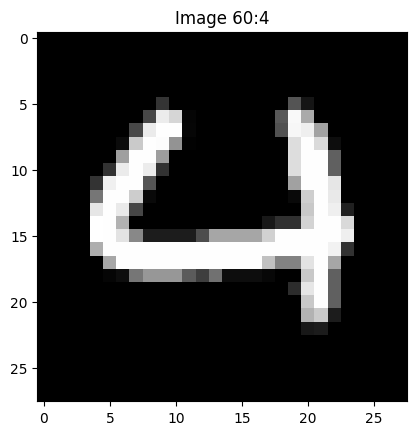

In [3]:
def plot_image(img_index):
    label_index = y_train_data[img_index]
    plt.imshow(x_train_data[img_index]/255, cmap = 'gray')
    plt.title("Image "+str(img_index)+":"+dataset_labels[label_index])

img_index = 60
plot_image(img_index)

## 1.2 Normalizacja danych
Na początek sprawdzamy jakie są max i min wartości pixeli w obrazkach.

Wartości te powinny być zawarte w przedziale [0,1].

In [4]:
print("Wartości min:",np.min(x_train_data)," max:",np.max(x_train_data))

x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255

print("Wartości po przeskalowaniu min:",np.min(x_train_data)," max:",np.max(x_train_data))


Wartości min: 0  max: 255
Wartości po przeskalowaniu min: 0.0  max: 1.0


## 1.3 Podział zbioru danych na zbiór treningowy/walidacyjny/testowy
*   **Zbiór treningowy** - wykorzystamy go do uczenia.
*   **Zbiór walidacyjny** - wykorzystamy go do tuningu hiperparametrów.
*   **Zbiór testowy** - wykorzystamy go do ostatecznego sprawdzenia modelu.

Zbiór walidacyjny stworzymy z 10% zbioru treningowego.

In [5]:
validation_fraction = .1

total_train_samples = len(x_train_data)
validation_samples = int(total_train_samples * validation_fraction)
train_samples = total_train_samples - validation_samples

(x_train, x_valid) = x_train_data[:train_samples], x_train_data[train_samples:]
(y_train, y_valid) = y_train_data[:train_samples], y_train_data[train_samples:]

x_test, y_test = x_test_data, y_test_data
print(train_samples, validation_samples, len(x_test))

54000 6000 10000


## 1.4 Dwa dodatkowe kroki
1. Większość zestawów danych obrazu składa się z obrazów rgb. Z tego powodu Keras oczekuje, że każdy obraz będzie miał 3 wymiary: [x_pixels, y_pixels, color_channels]. Ponieważ nasze obrazki są w skali szarości, wymiar koloru jest równy 1. Musimy zatem zmienić kształt obrazków.

2. W procesie uczenia naszego modelu będziemy wykorzystwali tzw. **kategoryczną entropię krzyżową** (https://keras.io/losses/). Musimy przekształcić wektory z etykietami (labelami) do **kodowania one-hot**. Wykorzystamy do tego funkcję tf.keras.utils.to_categorical().

In [6]:
# Zmieniamy kształ z (28, 28) na (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# Kodowanie one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Ilość elmentów w zbiorach
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')


x_train shape: (54000, 28, 28, 1) y_train shape: (54000, 10)
54000 train set
6000 validation set
10000 test set


# 2 Stworzenie modelu

Keras oferuje dwa API:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/models/model/)

W naszym modelu wykorzystamy Sequential model API. Będziemy wykorzystwali następujące metody:

*   Dense()    [link text](https://keras.io/layers/core/) - tworzy **warstwę gęstą**
*   Conv2D()   [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - tworzy **warstwę konwolucyjną**
*   Pooling()  [link text](https://keras.io/layers/pooling/) - tworzy **warstwę pooling**
*   Dropout()  [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - zastowanie **dropout**

## 2.0 Prosty model liniowy
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera adam**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [8]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???


## Uczenie modelu

Model uczymy wykorzystując fit().

In [9]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 5, validation_data = (x_valid,y_valid))

Epoch 1/5
844/844 [==============================] - 9s 8ms/step - loss: 0.5838 - accuracy: 0.8506 - val_loss: 0.2990 - val_accuracy: 0.9217
Epoch 2/5
844/844 [==============================] - 5s 6ms/step - loss: 0.3377 - accuracy: 0.9074 - val_loss: 0.2616 - val_accuracy: 0.9287
Epoch 3/5
844/844 [==============================] - 6s 7ms/step - loss: 0.3056 - accuracy: 0.9153 - val_loss: 0.2440 - val_accuracy: 0.9333
Epoch 4/5
844/844 [==============================] - 3s 3ms/step - loss: 0.2911 - accuracy: 0.9193 - val_loss: 0.2362 - val_accuracy: 0.9342
Epoch 5/5
844/844 [==============================] - 2s 3ms/step - loss: 0.2823 - accuracy: 0.9207 - val_loss: 0.2326 - val_accuracy: 0.9367


Wykresy precyzji i błędu

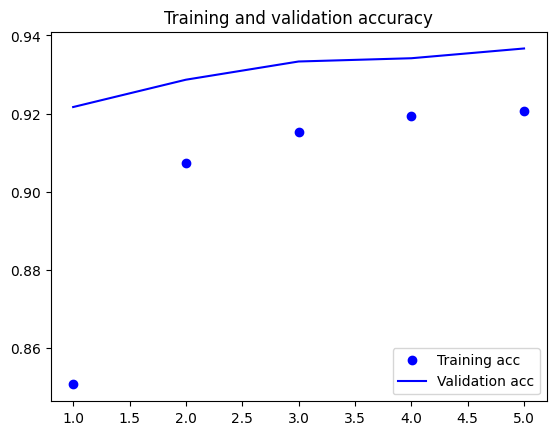

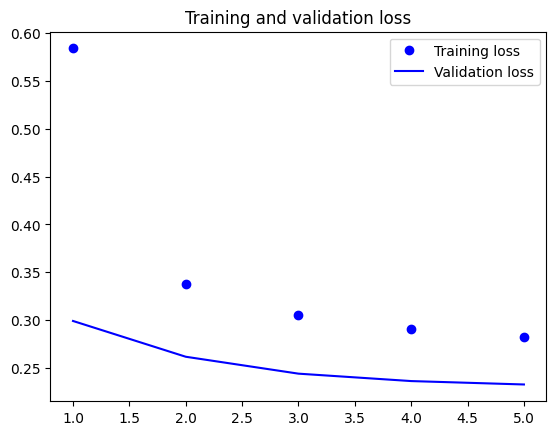

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [11]:
model.save("mnist_simple.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Wczytanie modelu

In [12]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [13]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.9244999885559082


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 1s 1ms/step


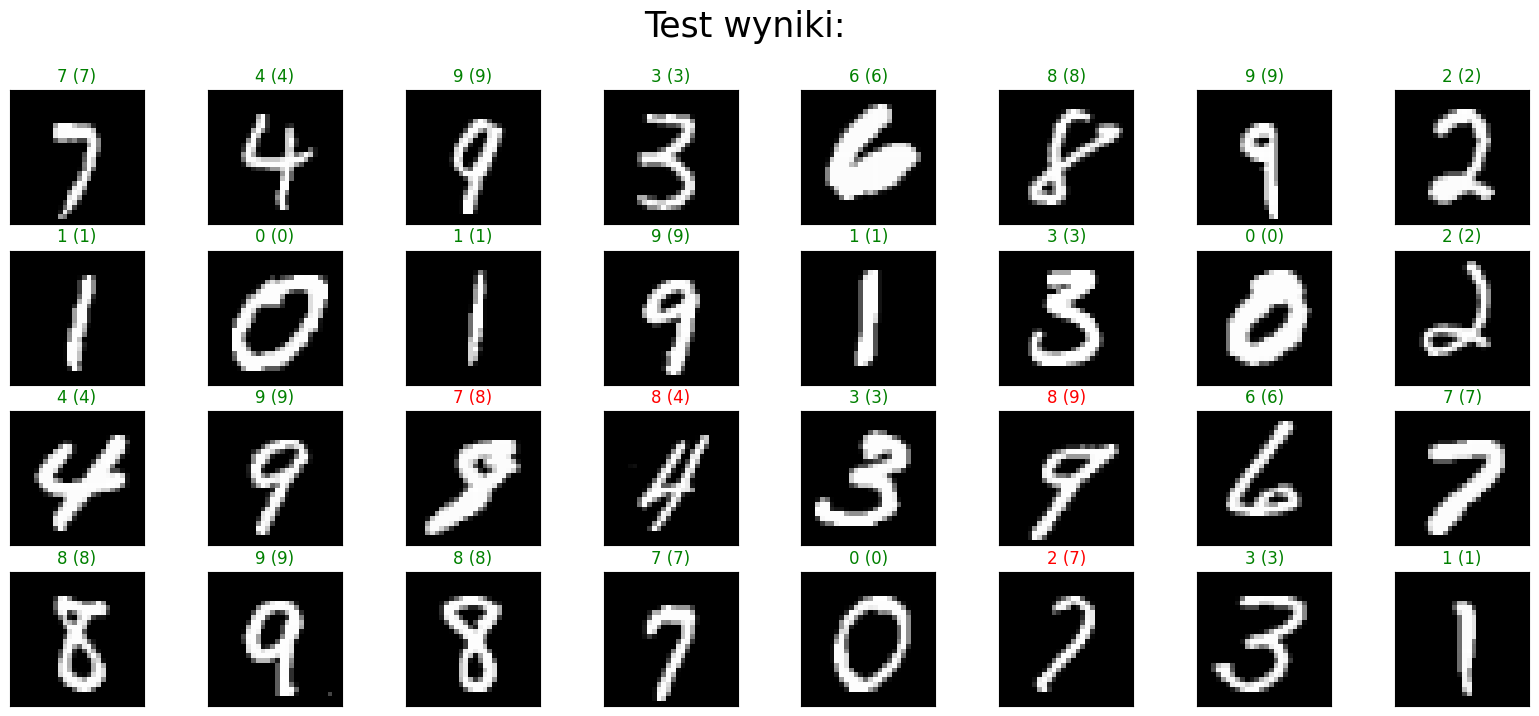

In [14]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



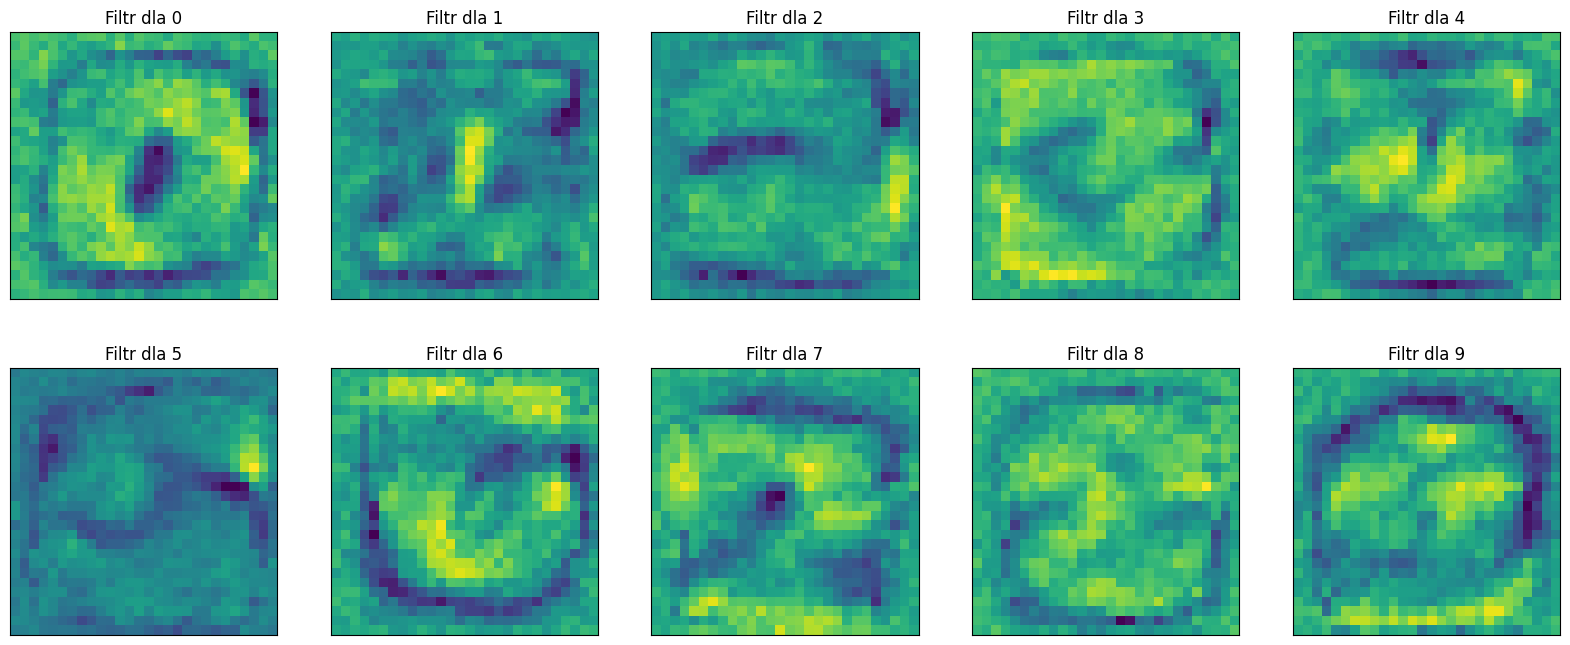

In [15]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

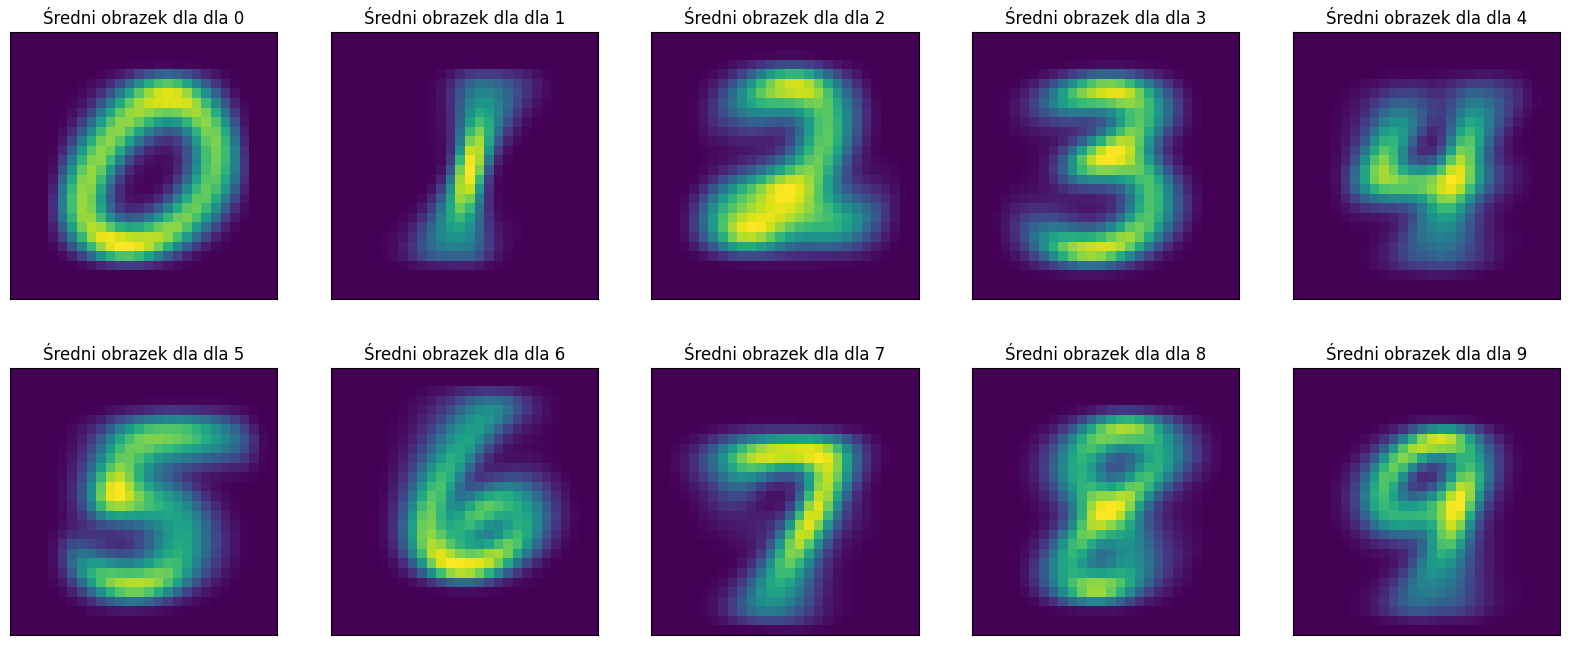

In [16]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


## 2.0 Prosty model liniowy v2
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [46]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera adam**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [47]:
opt = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???


## Uczenie modelu

Model uczymy wykorzystując fit().

In [48]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 5, validation_data = (x_valid,y_valid))

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4105 - accuracy: 0.8882 - val_loss: 0.2464 - val_accuracy: 0.9313
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2977 - accuracy: 0.9161 - val_loss: 0.2368 - val_accuracy: 0.9327
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2817 - accuracy: 0.9210 - val_loss: 0.2271 - val_accuracy: 0.9377
Epoch 4/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2742 - accuracy: 0.9228 - val_loss: 0.2275 - val_accuracy: 0.9363
Epoch 5/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.2673 - accuracy: 0.9247 - val_loss: 0.2318 - val_accuracy: 0.9335


Wykresy precyzji i błędu

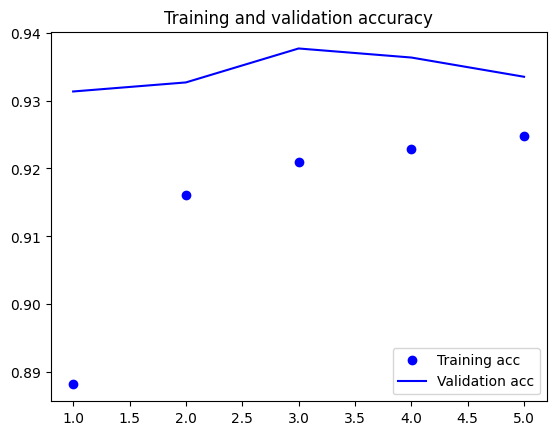

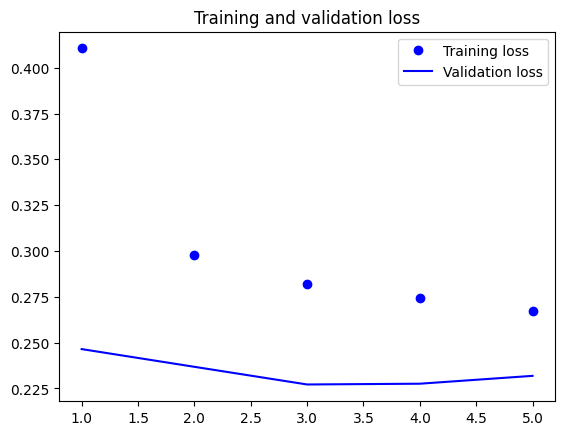

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [50]:
model.save("mnist_simple.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Wczytanie modelu

In [51]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [52]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.9204000234603882


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 0s 1ms/step


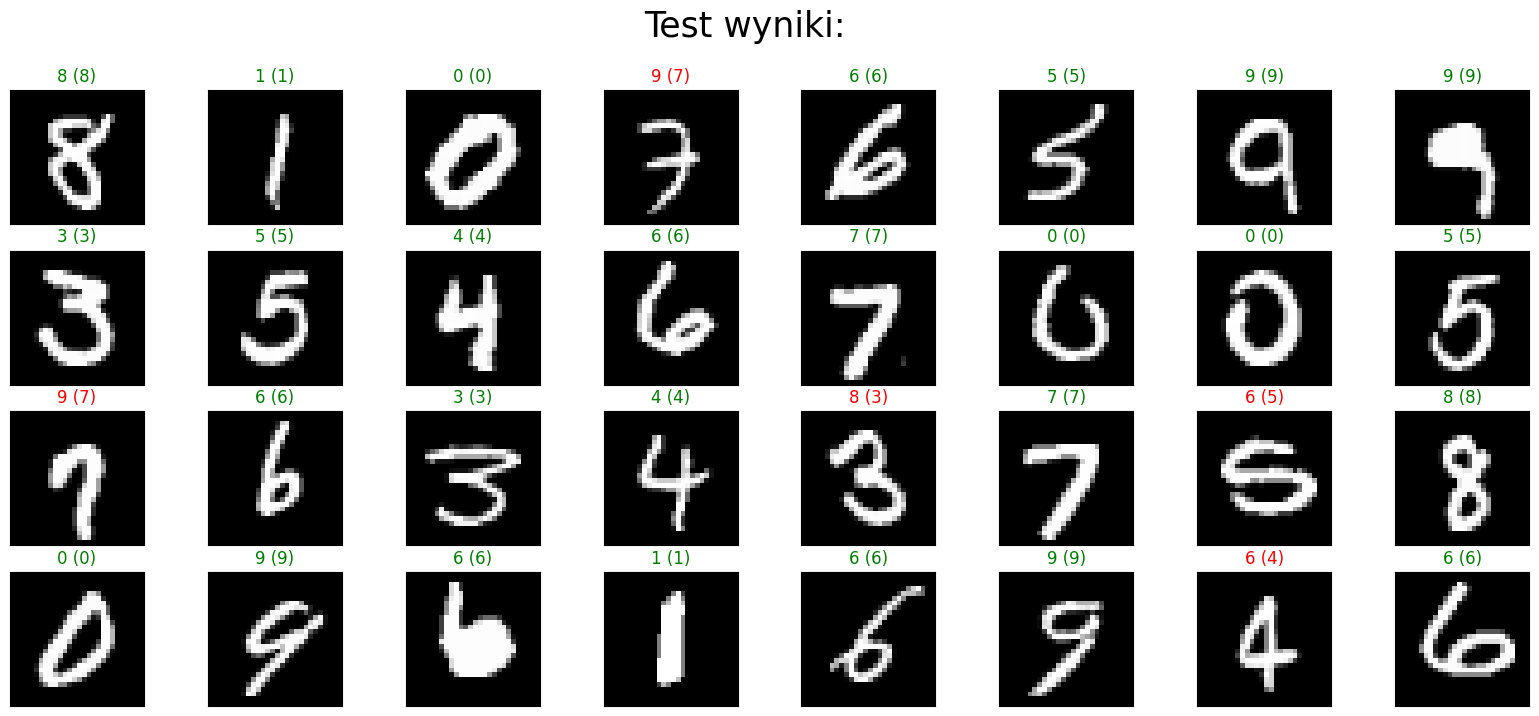

In [53]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



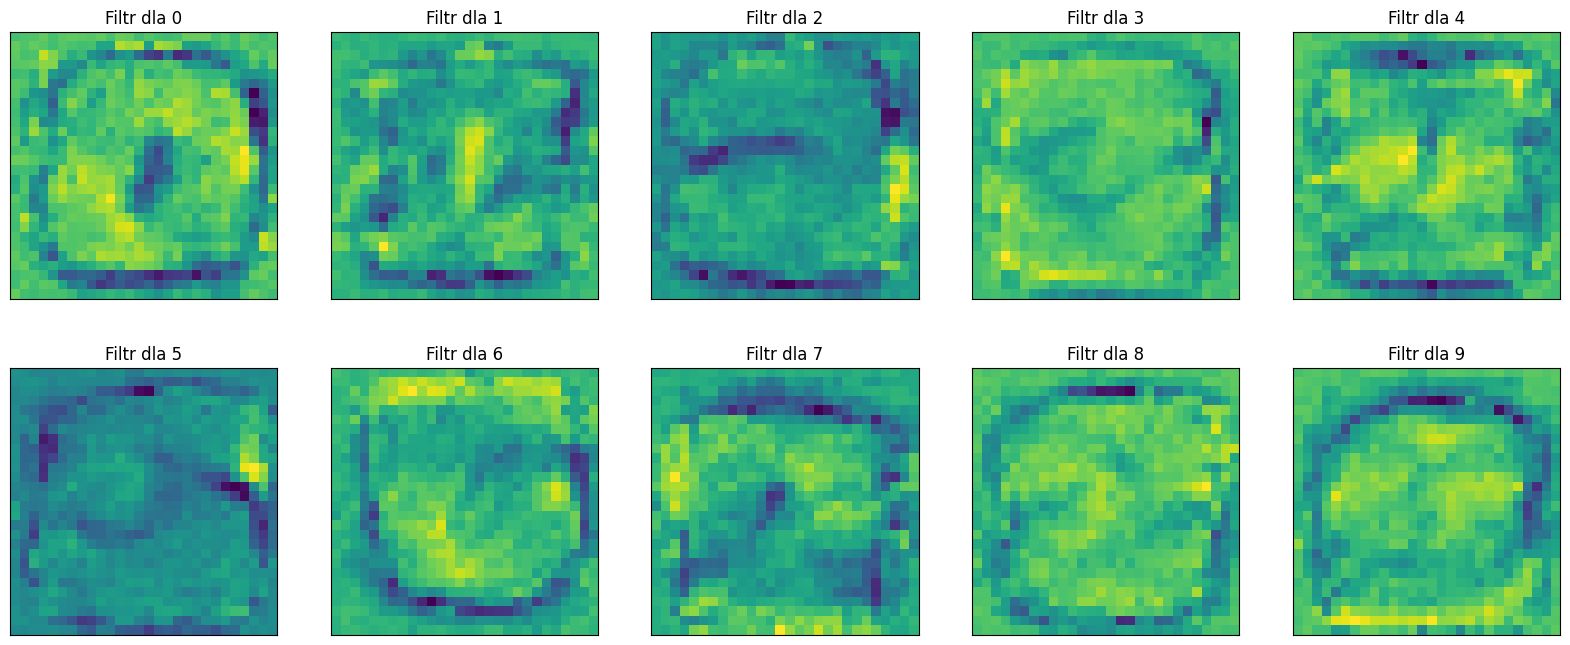

In [54]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

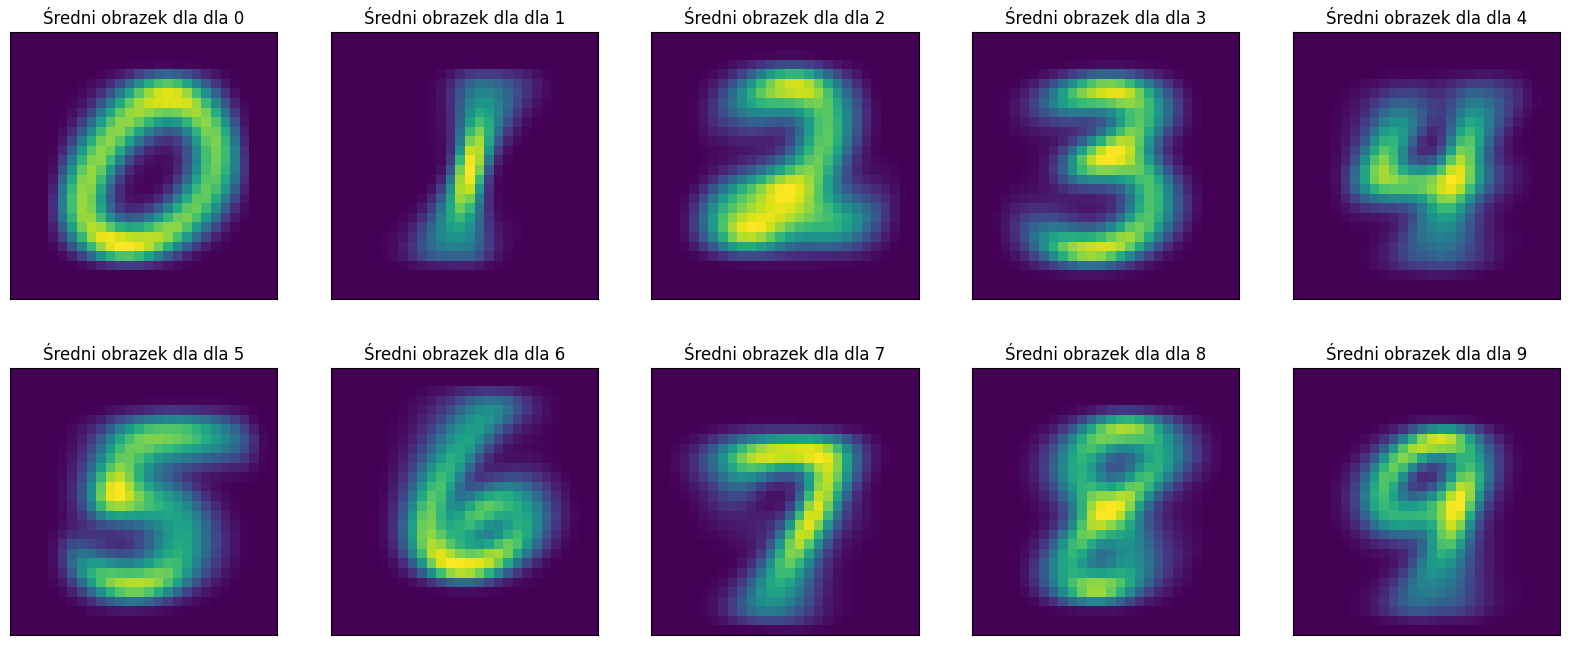

In [55]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


## 2.0 Prosty model liniowy v3
Zaczniemy od prostego modelu składającego się z jednej transformacji liniowej.

*  Model stworzymy za pomocą tf.keras.Sequential() (https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).
Ponieważ nie zastosujemy jeszcze konwolucji zatem możemy spłaszczyć obrazki do wektorów zawierających 28x28 wartości.

*  Następnie dodamy jedną warstwę liniową, która przkształci wejściowe piksele w 10 klas. Poniważ wyniki reprezentują prawdopodobieństwa możemy użyć funkcji aktywacji softmax.

*  Szczegóły modelu uzyskamy z pomocą model.summary()


In [102]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Kompilacja modelu
Uwagi:

*   Użyjemy **optymizera sgd**
*   Jako loss function użyjemy '**categorical_crossentropy**'
*   Lista parametrów, tutaj zaczniemy od '**precyzji**'

Warto zerknąć: https://keras.io/models/model/

In [103]:
opt = keras.optimizers.SGD(learning_rate=0.04)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Uczenie modelu

Model uczymy wykorzystując fit().

In [104]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 75, validation_data = (x_valid,y_valid))

Epoch 1/75
844/844 [==============================] - 3s 3ms/step - loss: 0.6500 - accuracy: 0.8391 - val_loss: 0.3658 - val_accuracy: 0.9075
Epoch 2/75
844/844 [==============================] - 3s 4ms/step - loss: 0.4070 - accuracy: 0.8892 - val_loss: 0.3132 - val_accuracy: 0.9173
Epoch 3/75
844/844 [==============================] - 2s 3ms/step - loss: 0.3685 - accuracy: 0.8976 - val_loss: 0.2937 - val_accuracy: 0.9213
Epoch 4/75
844/844 [==============================] - 2s 3ms/step - loss: 0.3485 - accuracy: 0.9026 - val_loss: 0.2802 - val_accuracy: 0.9247
Epoch 5/75
844/844 [==============================] - 2s 3ms/step - loss: 0.3357 - accuracy: 0.9061 - val_loss: 0.2726 - val_accuracy: 0.9250
Epoch 6/75
844/844 [==============================] - 2s 3ms/step - loss: 0.3263 - accuracy: 0.9085 - val_loss: 0.2671 - val_accuracy: 0.9262
Epoch 7/75
844/844 [==============================] - 3s 4ms/step - loss: 0.3194 - accuracy: 0.9106 - val_loss: 0.2633 - val_accuracy: 0.9273
Epoch 

Wykresy precyzji i błędu

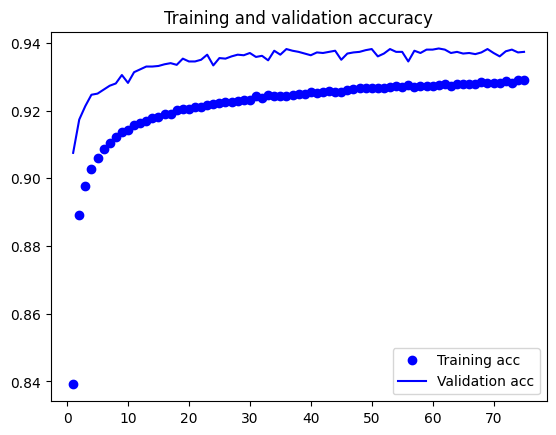

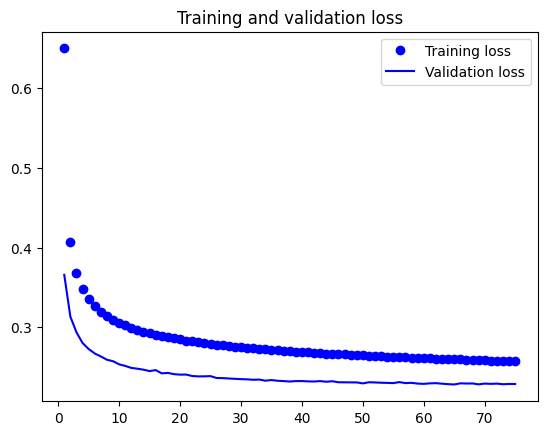

In [105]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Zapisanie i wczytanie modelu


Zapisanie modelu

In [106]:
model.save("mnist_simple.h5")

Wczytanie modelu

In [107]:
#from keras.models import load_model
#model = load_model("mnist_simple.h5")

## Precyzja
Wykorzystamy funkcję evaluate()

In [108]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test accuracy:',score[1])

Test accuracy: 0.9243000149726868


## Przewidywania modelu
Przetestujmy przewidywania naszego modelu. Sprawdzimy go na danych testowych. W tym celu wykorzystamy poniższą funkcję 'visualize_model_predictions(model, x, y)'

313/313 [==============================] - 0s 1ms/step


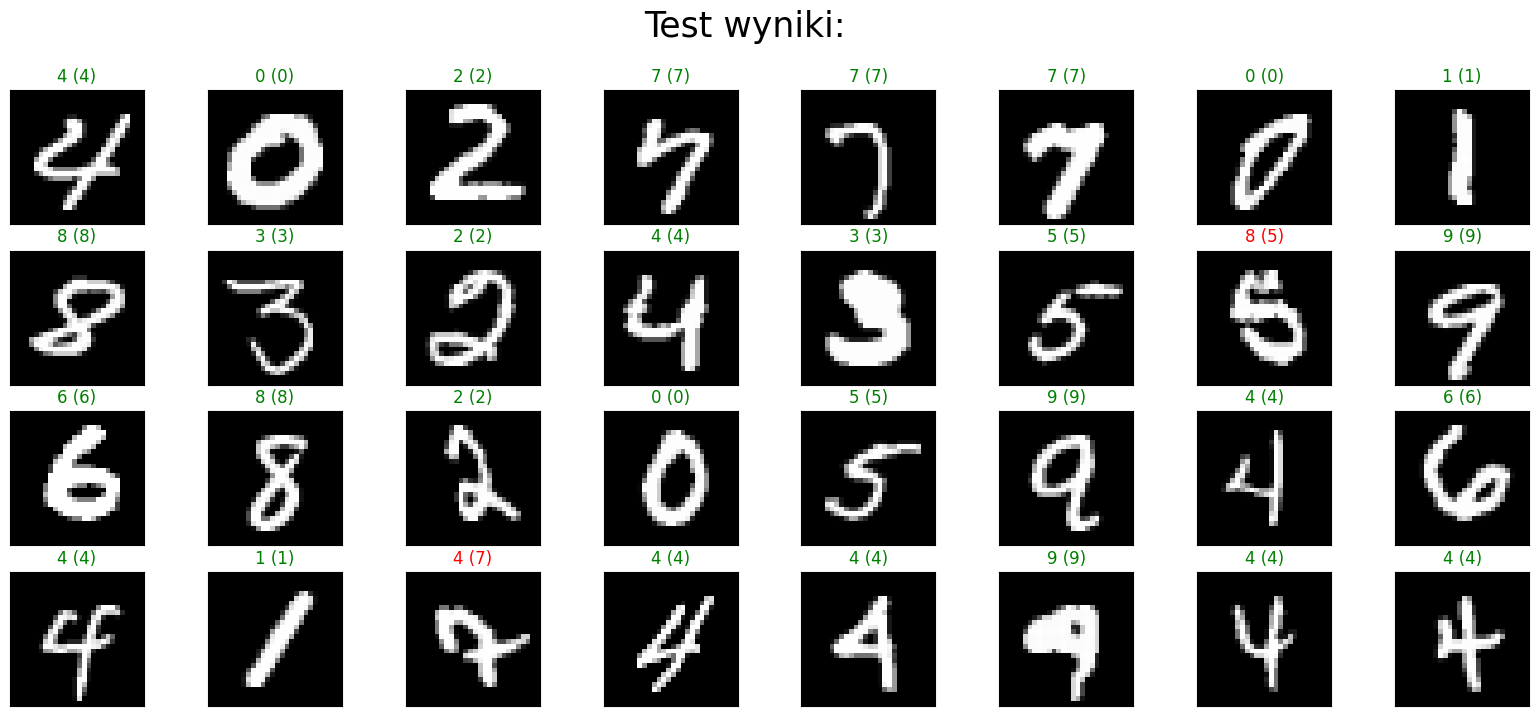

In [109]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        ax.set_title("{} ({})".format(dataset_labels[predict_index],
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s wyniki:" %title_string, fontsize=25)

visualize_model_predictions(model, x_test, y_test, 'Test')


## 1. Wizualizacja wag dla każdej klasy
Warstwę transformacyjną naszgo modelu można przedstawić za pomocą macierzy wag [28x28, 10]. Spróbujmy narysować każdy z 10 filtrów. W celu uzyskania wag modelu wykorzystamy funkcje model.layers i get_weights().



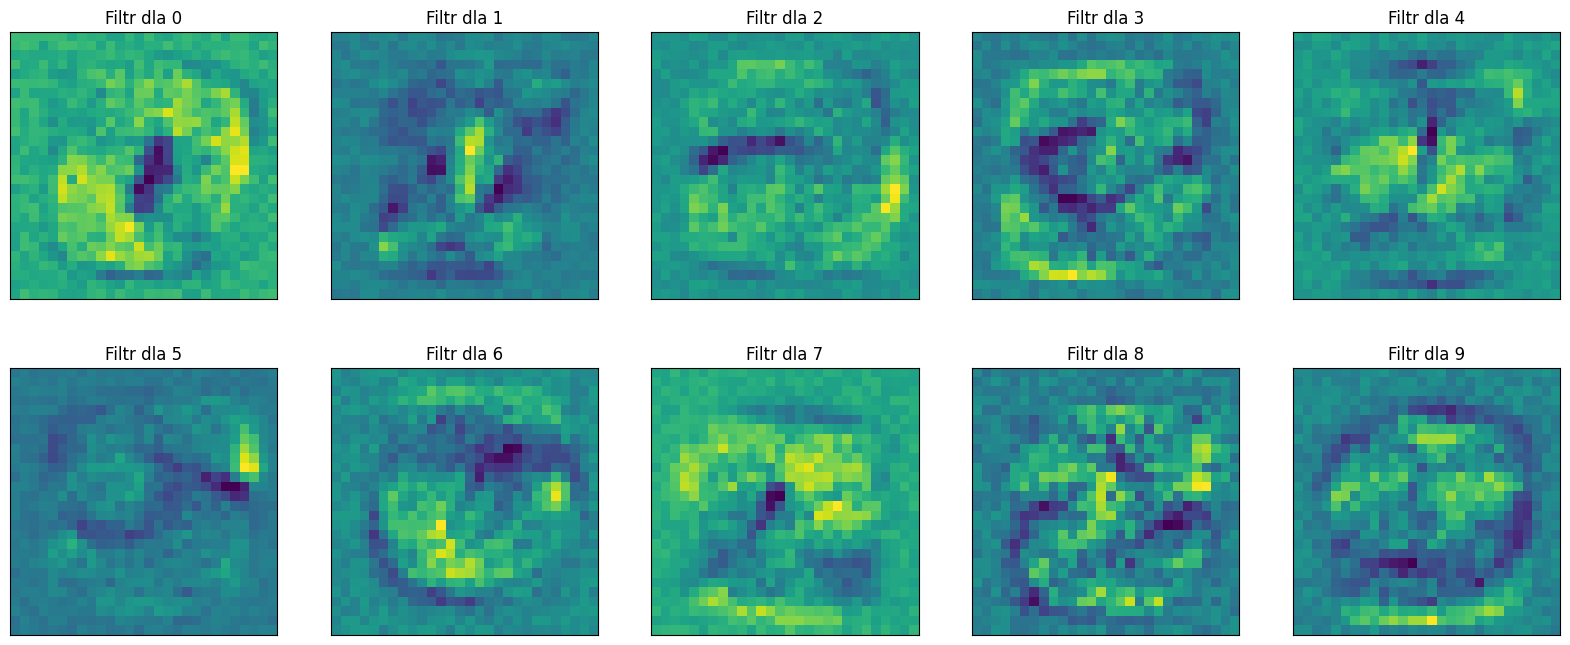

In [110]:
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        w,b = weights
        filters = np.reshape(w, (28,28,10))

def visualize_filters(filters, title_string):
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
        ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(filters[:,:,i], cmap = 'viridis')
        ax.set_title("%s dla %s" %(title_string, dataset_labels[i]))

visualize_filters(filters, 'Filtr')

## 2 I jeszcze jedna wizualizacja
Porównajmy powyższe filtry, ze średnim zdjęciem dla każdej klasy.

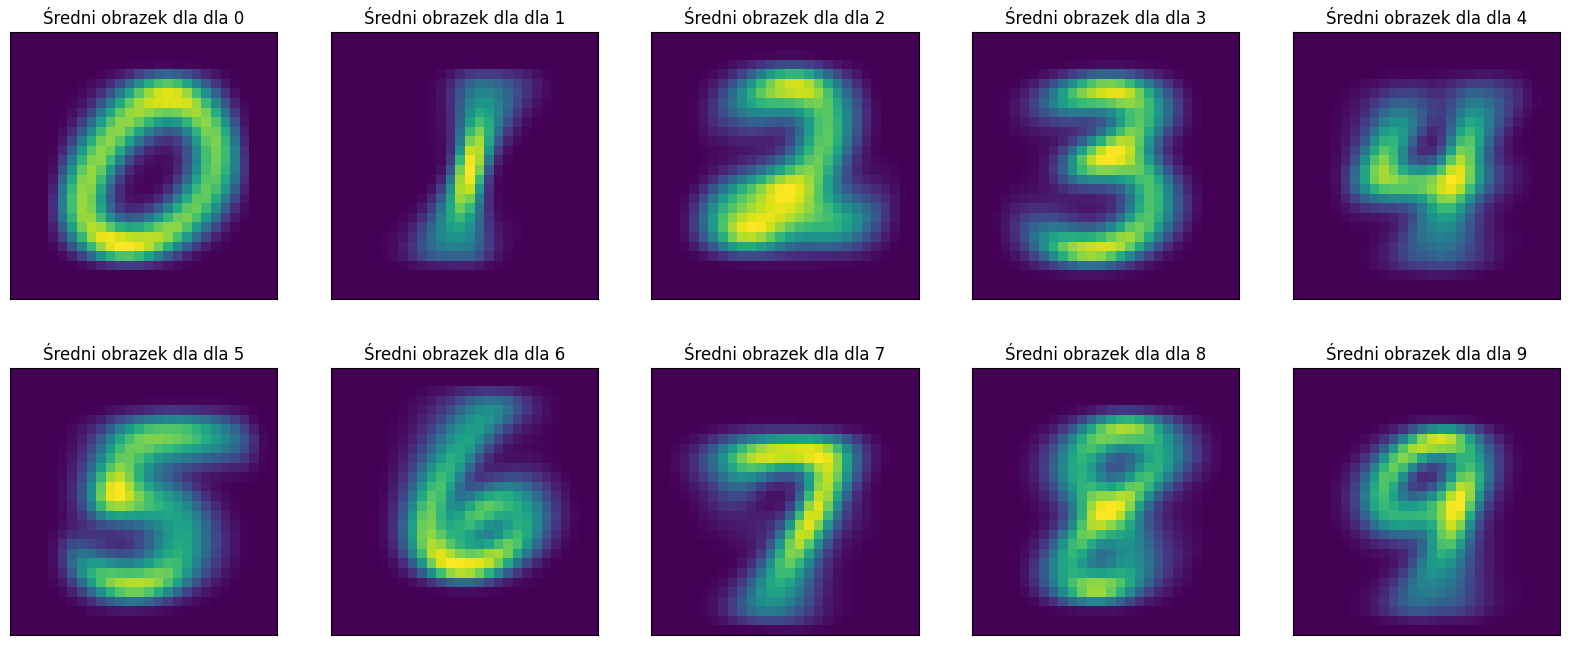

In [111]:
avg_images = np.zeros((28,28,1,10))
class_images = [0]*10

for i in range(len(x_train)):
    img = x_train[i]
    label = np.argmax(y_train[i])

    avg_images[:,:,:,label] += img
    class_images[label] += 1

for i in range(10):
    avg_images[:,:,:,i] = avg_images[:,:,:,i]/class_images[i]

avg_images = np.squeeze(avg_images)
visualize_filters(avg_images, 'Średni obrazek dla')


# 2.1 A teraz sieć neuronowa
Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(60,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                47100     
                                                                 
 dense_2 (Dense)             (None, 10)                610       
                                                                 
Total params: 47710 (186.37 KB)
Trainable params: 47710 (186.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
844/844 [==============================] - 4s 3ms/step - loss: 0.3693 - accuracy: 0.8986 - val_loss: 0.1734 - val_accuracy: 0.9537
Epoch 2/10
844/844 [==============================] - 3s 4ms/step - loss: 0.1755 - accuracy: 0.9497 - val_loss: 0.1264 - val_accuracy: 0.9

Precyzja

In [18]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9746000170707703


Wykresy precyzji i błędu

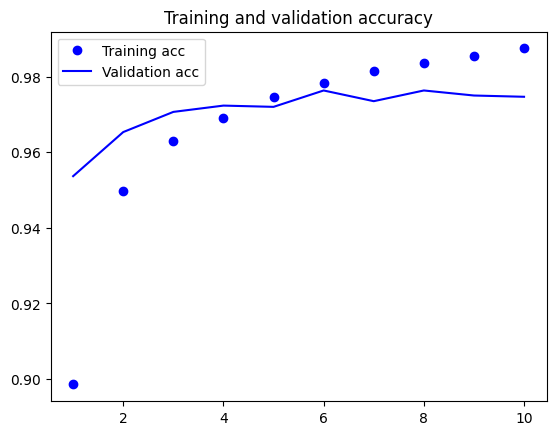

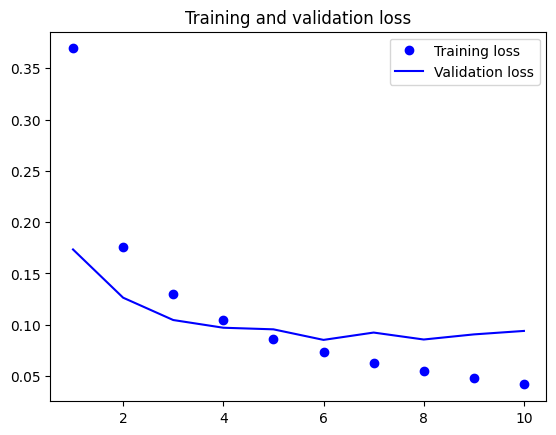

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 1s 2ms/step


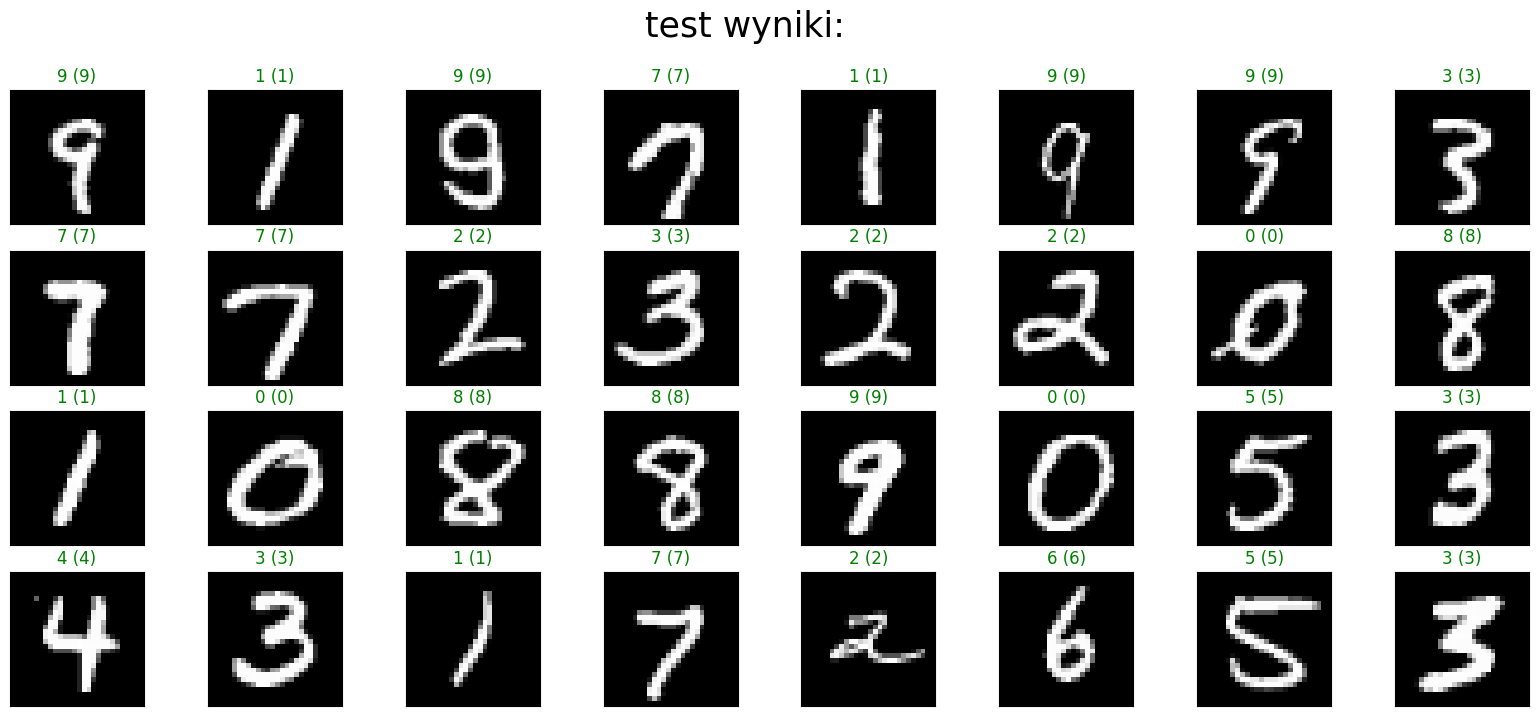

In [20]:
visualize_model_predictions(model, x_test, y_test, "test" )

# 2.1 Sieć neuronowa v2
Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [122]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
opt = keras.optimizers.Adam(learning_rate=0.004)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) #learnig rate???

history = model.fit(x_train, y_train, batch_size = 64, epochs = 13, validation_data = (x_valid,y_valid))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                50240     
                                                                 
 dense_38 (Dense)            (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/13
844/844 [==============================] - 3s 3ms/step - loss: 0.2624 - accuracy: 0.9215 - val_loss: 0.1202 - val_accuracy: 0.9658
Epoch 2/13
844/844 [==============================] - 3s 3ms/step - loss: 0.1204 - accuracy: 0.9627 - val_loss: 0.1179 - val_accuracy: 0.

Precyzja

In [123]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.972100019454956


Wykresy precyzji i błędu

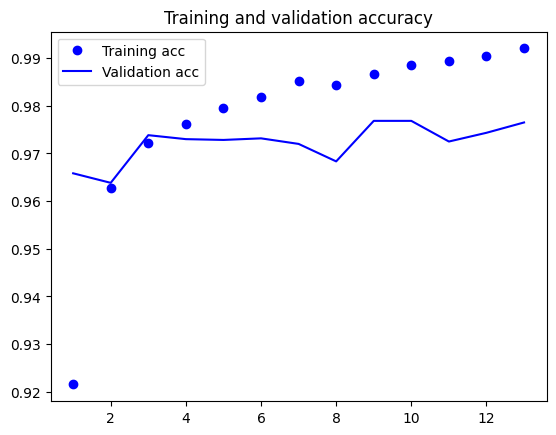

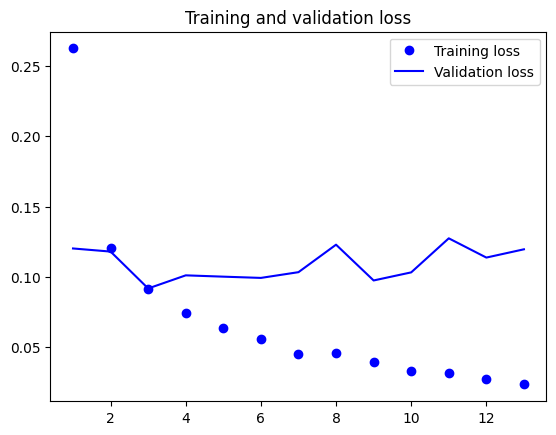

In [124]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 0s 1ms/step


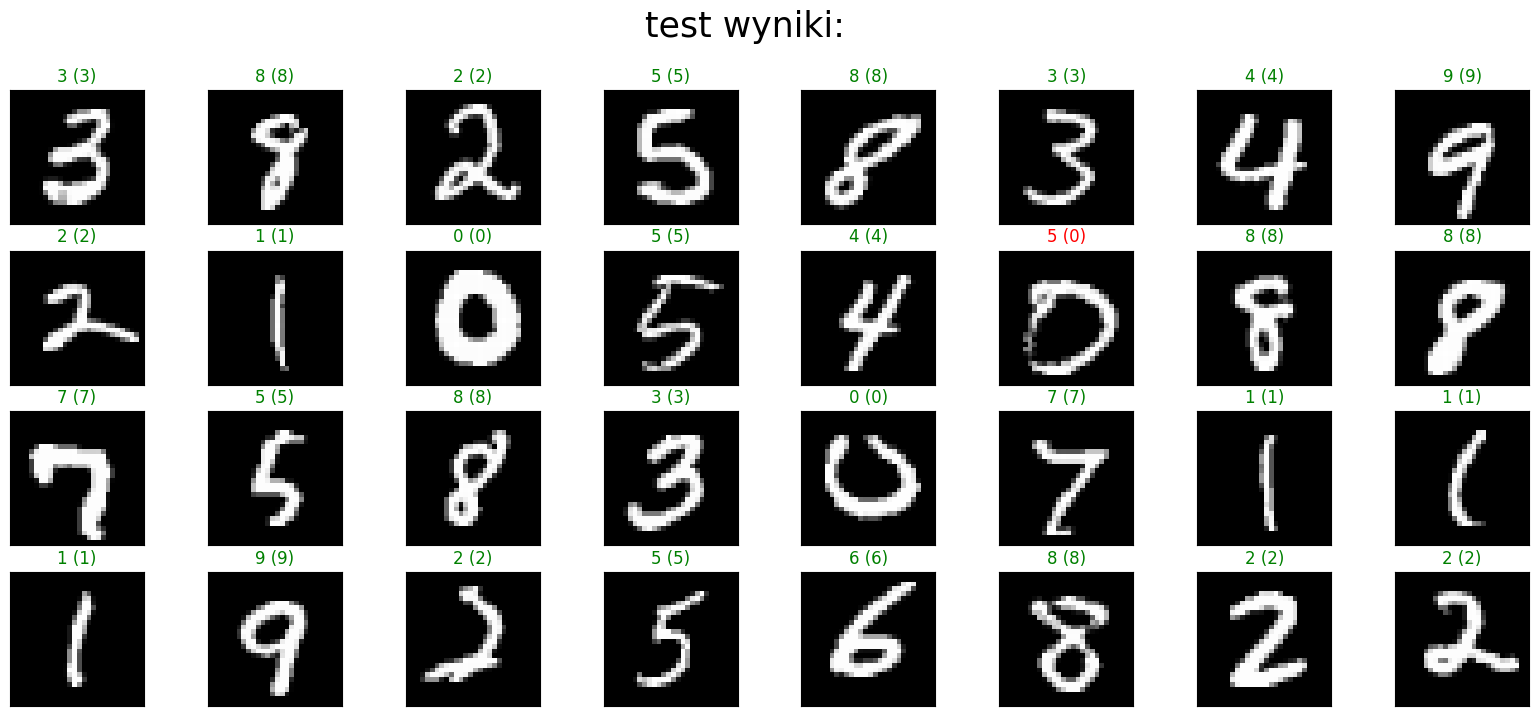

In [125]:
visualize_model_predictions(model, x_test, y_test, "test" )

# 2.1 Sieć neuronowa v3

Dodajmy teraz warstwy wewnętrzne w naszej sieci. Funkcja aktywacji w takich warstwach to zwykle relu.

In [129]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
opt = keras.optimizers.SGD(learning_rate=0.08)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 128, epochs = 50, validation_data = (x_valid,y_valid))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_45 (Dense)            (None, 64)                50240     
                                                                 
 dense_46 (Dense)            (None, 10)                650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 50890 (198.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
422/422 [==============================] - 2s 4ms/step - loss: 0.5471 - accuracy: 0.8533 - val_loss: 0.2703 - val_accuracy: 0.9250
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3059 - accuracy: 0.9135 - val_loss: 0.2322 - val_accuracy: 0.

Precyzja

In [130]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9751999974250793


Wykresy precyzji i błędu

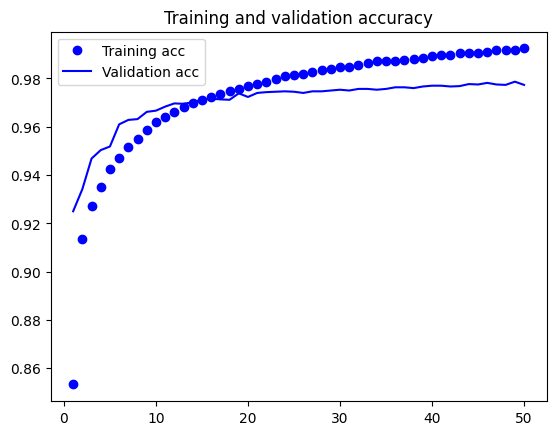

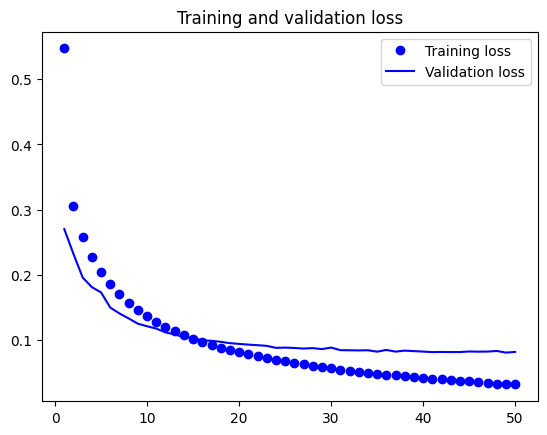

In [131]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Przewidywania modelu
Sprawdźmy jakie są przewidywania naszego modelu

313/313 [==============================] - 1s 2ms/step


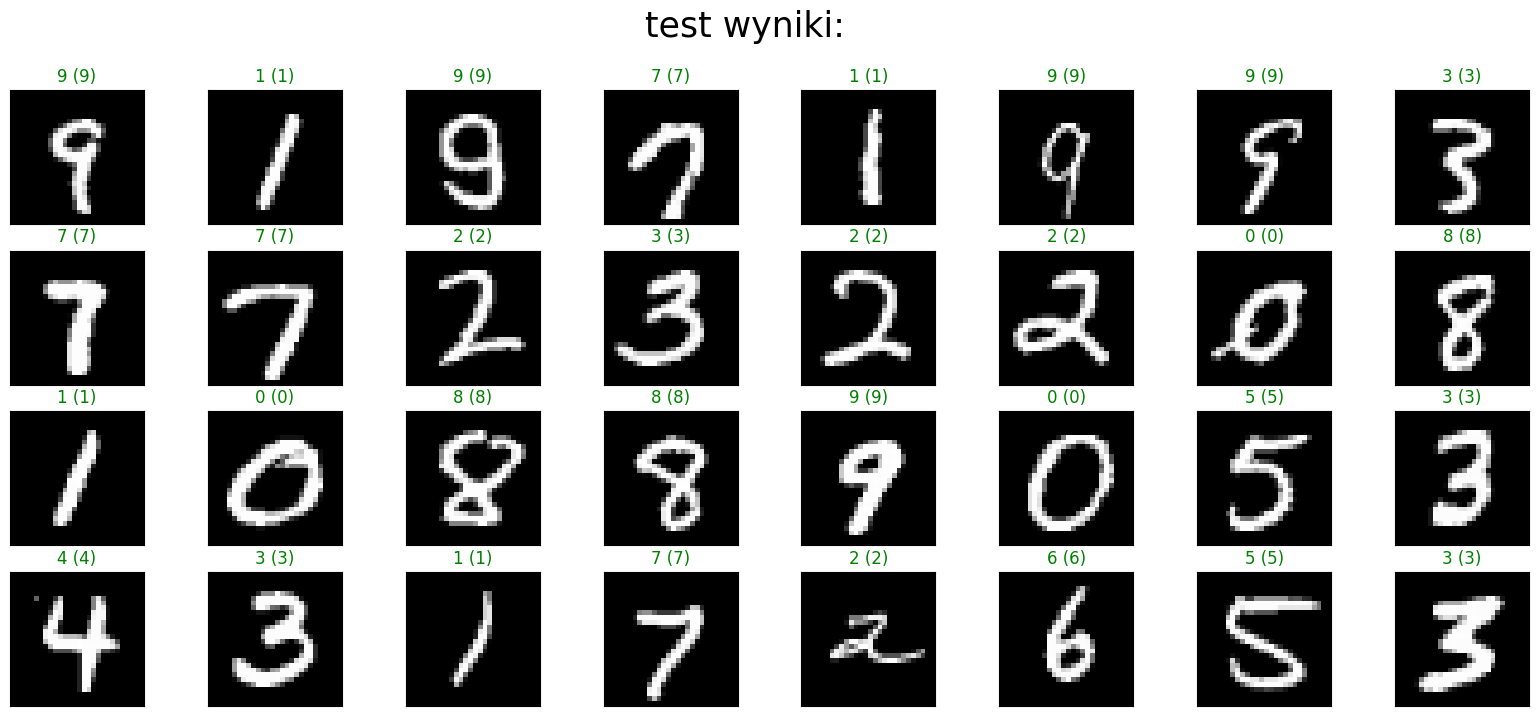

In [ ]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Spróbujmy pogłębić nasz model!
Dodajmy 3 warstwy gęste.

In [21]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 115306 (450.41 KB)
Trainable params: 115

Wykresy precyzji i błędu

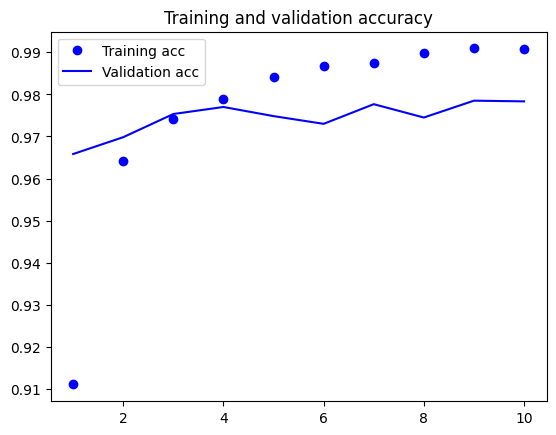

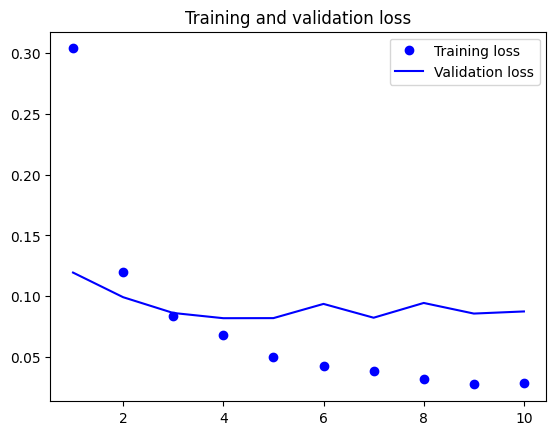

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


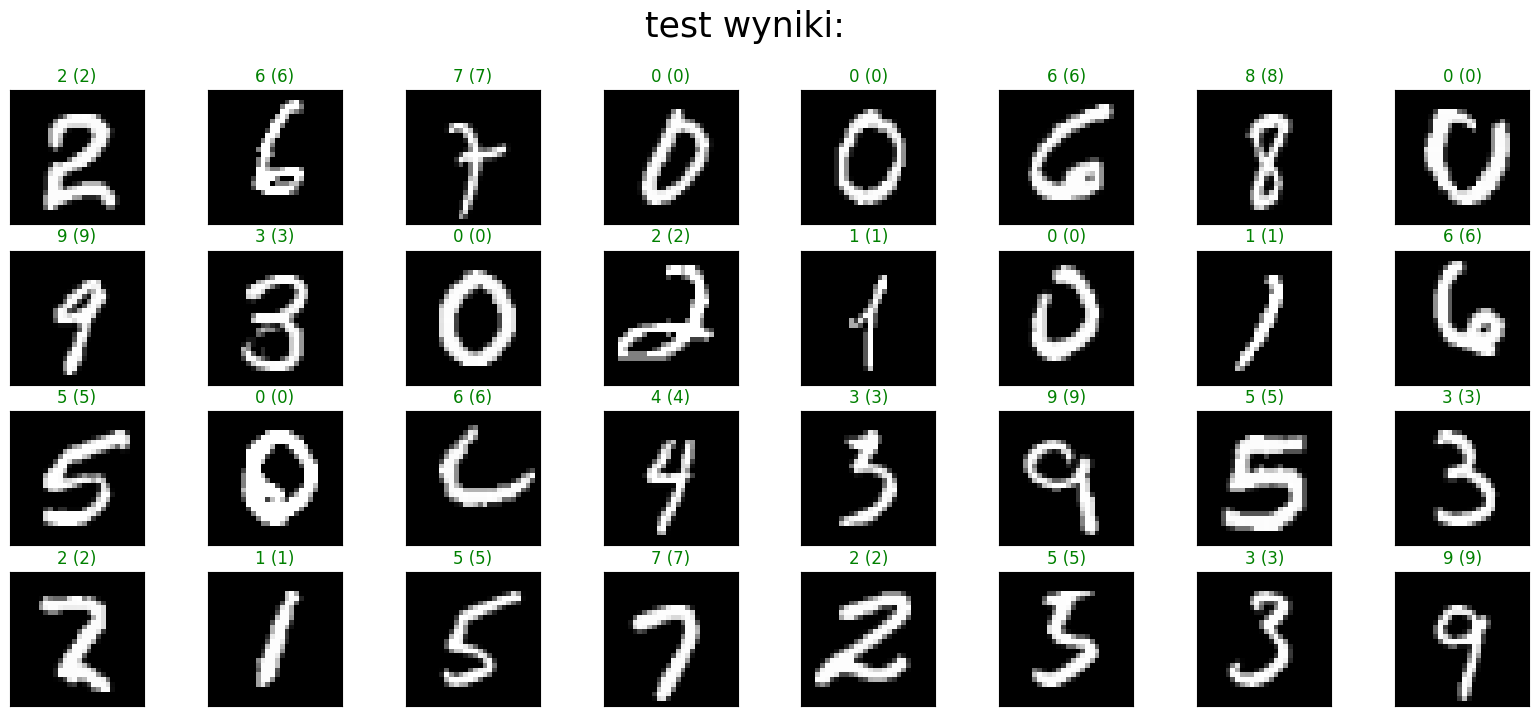

In [23]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Pogłębinienie modelu v2
Dodajmy 2 warstwy gęste.

In [132]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               100480    
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 10)                330       
                                                                 
Total params: 111146 (434.16 KB)
Trainable params: 111146 (434.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
84

Wykresy precyzji i błędu

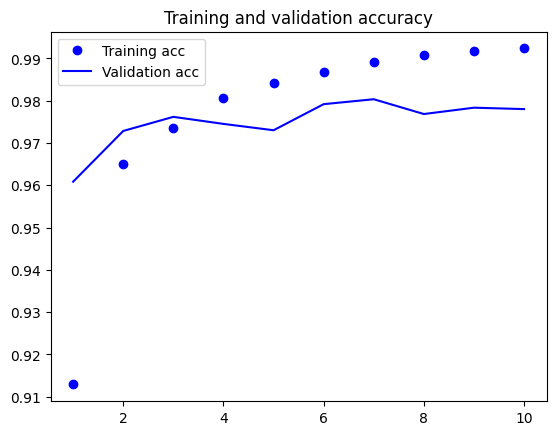

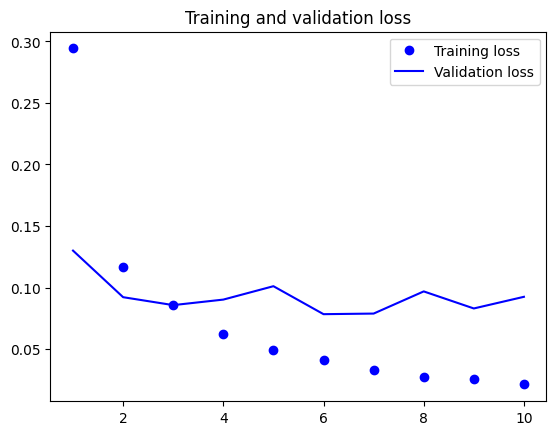

In [133]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


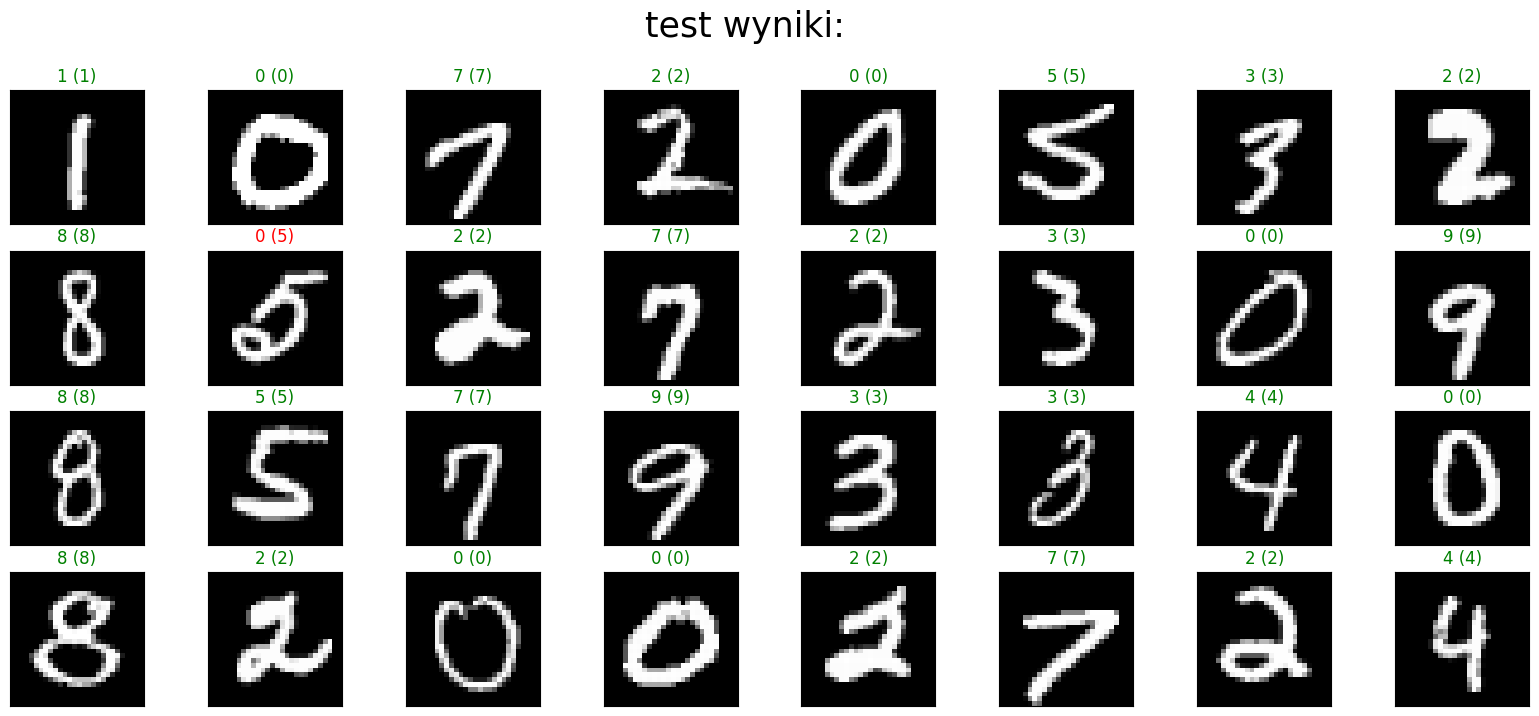

In [134]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.2 Pogłębiamy model v3
Dodajmy 4 warstwy gęste.

In [135]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_valid,y_valid))

score = model.evaluate(x_test,y_test,verbose=0)
print('Precyzja: ',score[1])



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 784)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               100480    
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 64)                4160      
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 10)              

Wykresy precyzji i błędu

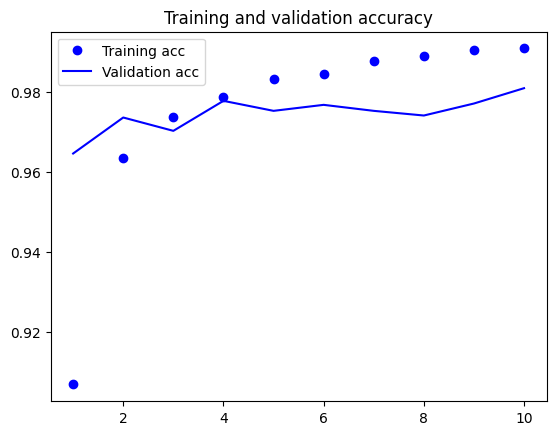

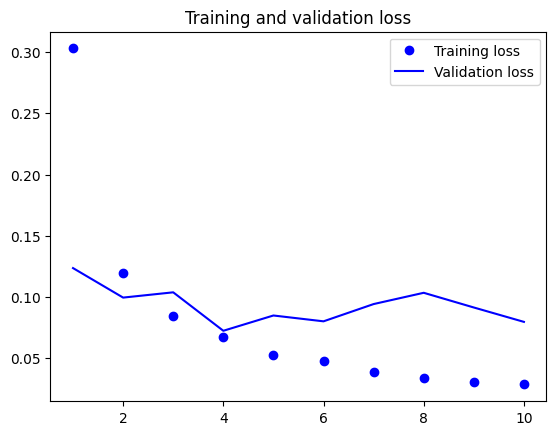

In [136]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


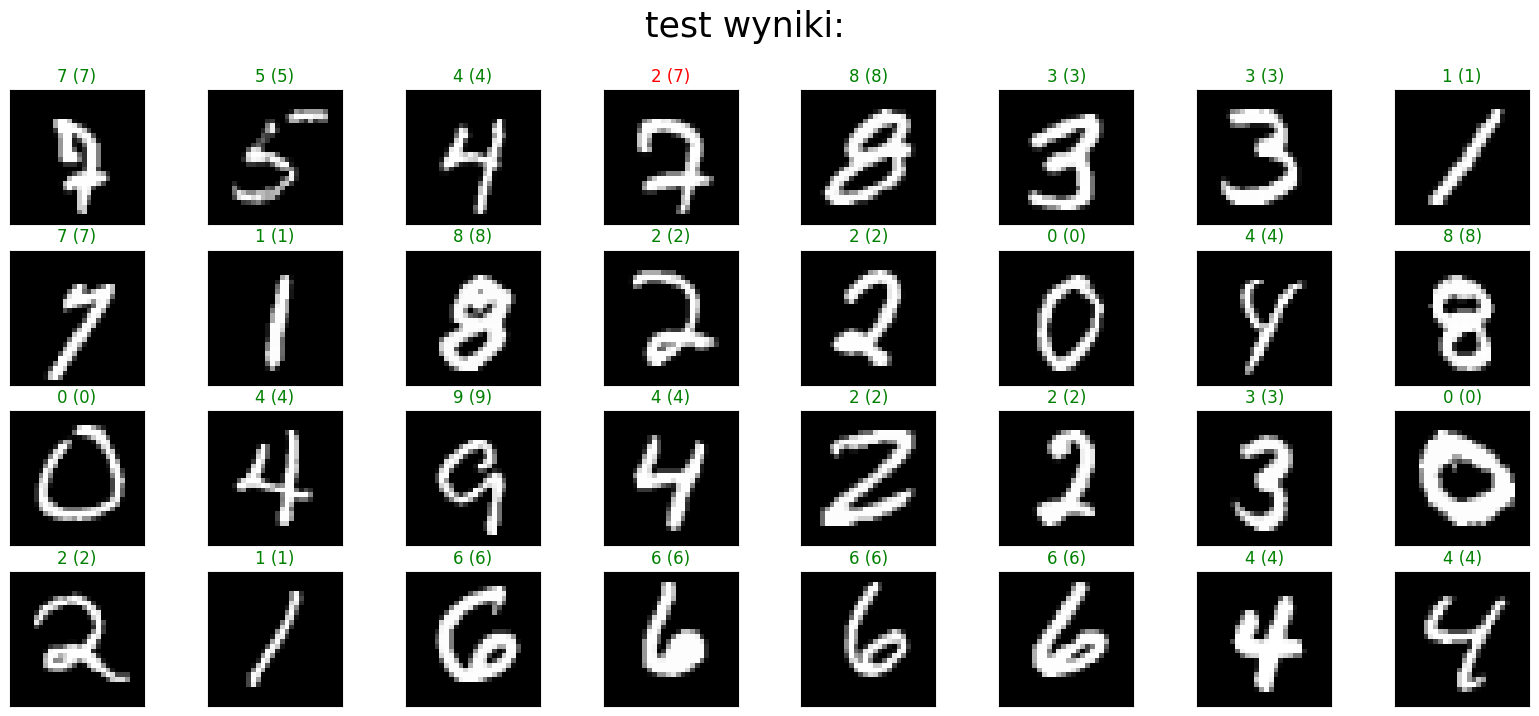

In [138]:
visualize_model_predictions(model, x_test, y_test, "test" )

## 2.3 Konwolucja

W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [24]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         20        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 2)         34        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 2)           0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 98)                0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [25]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 5ms/step - loss: 0.6456 - accuracy: 0.8120 - val_loss: 0.2564 - val_accuracy: 0.9202
Epoch 2/25
422/422 [==============================] - 2s 4ms/step - loss: 0.2554 - accuracy: 0.9202 - val_loss: 0.1794 - val_accuracy: 0.9455
Epoch 3/25
422/422 [==============================] - 2s 4ms/step - loss: 0.1903 - accuracy: 0.9398 - val_loss: 0.1564 - val_accuracy: 0.9518
Epoch 4/25
422/422 [==============================] - 2s 4ms/step - loss: 0.1560 - accuracy: 0.9503 - val_loss: 0.1370 - val_accuracy: 0.9587
Epoch 5/25
422/422 [==============================] - 2s 4ms/step - loss: 0.1347 - accuracy: 0.9570 - val_loss: 0.1276 - val_accuracy: 0.9618
Epoch 6/25
422/422 [==============================] - 2s 6ms/step - loss: 0.1176 - accuracy: 0.9624 - val_loss: 0.1130 - val_accuracy: 0.9675
Epoch 7/25
422/422 [==============================] - 2s 4ms/step - loss: 0.1051 - accuracy: 0.9662 - val_loss: 0.1122 - val_accuracy: 0.9672
Epoch 

## Ewaluacja modelu

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9750000238418579


Wykresy precyzji i błędu

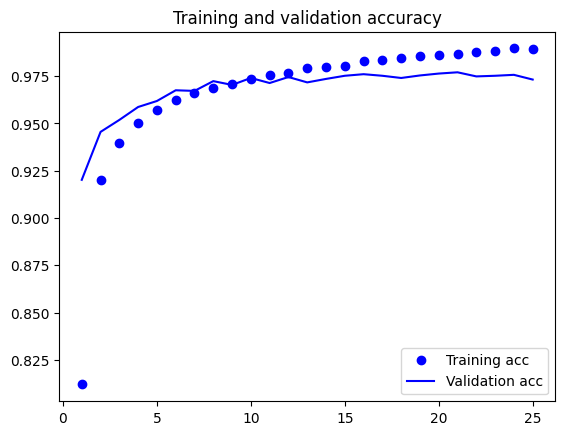

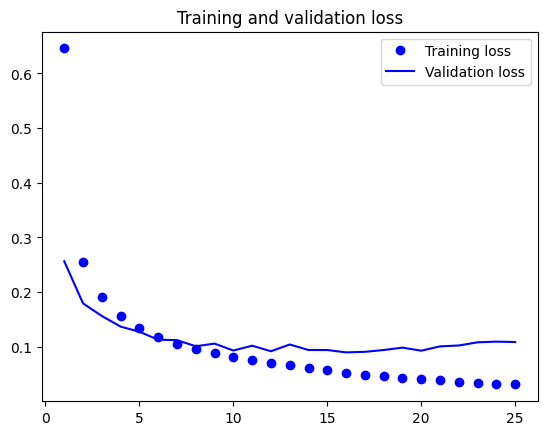

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


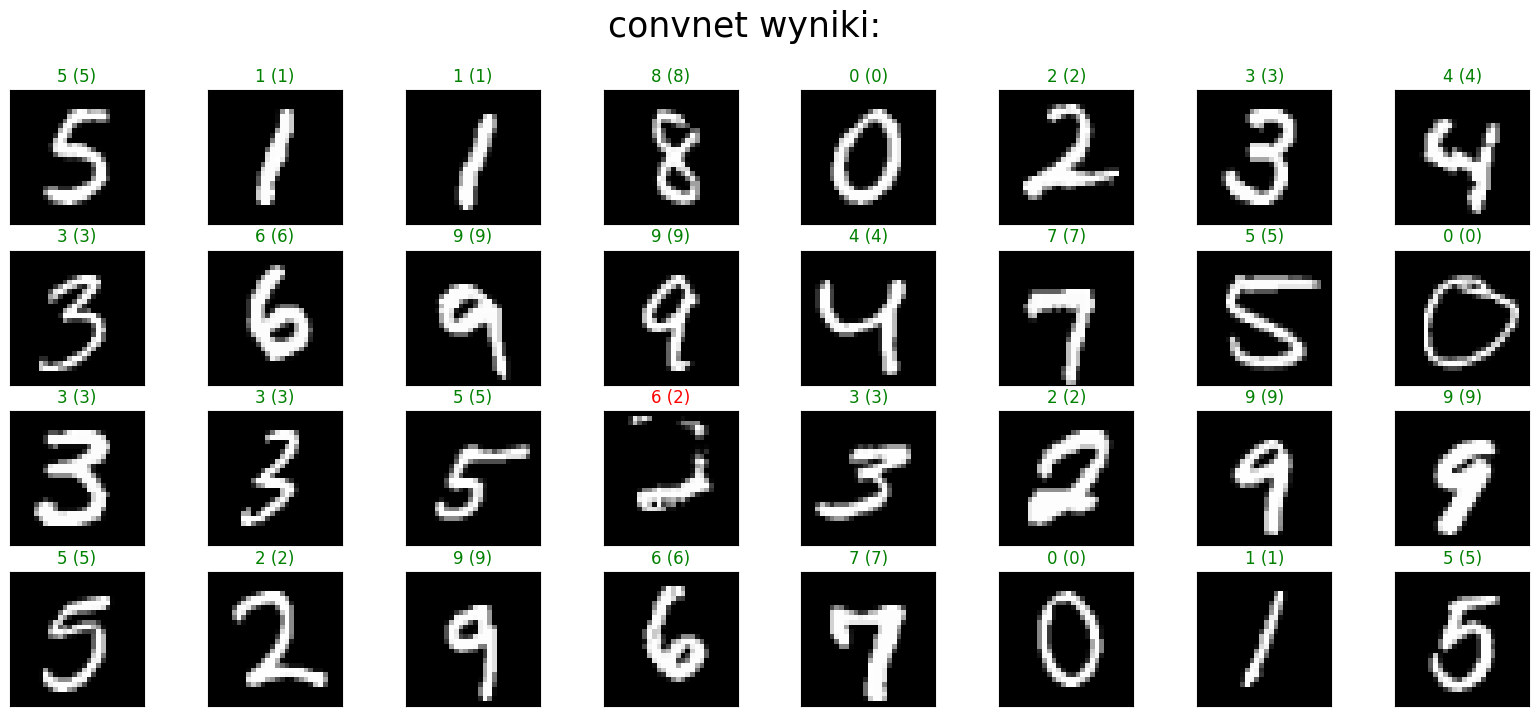

In [28]:
visualize_model_predictions(model, x_test, y_test,"convnet")

## 2.3 Konwolucja model v2
W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [150]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 4)         20        
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 2)         34        
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 2)           0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 2)           18        
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 3, 3, 2)         

In [151]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 4s 6ms/step - loss: 0.8775 - accuracy: 0.7366 - val_loss: 0.3990 - val_accuracy: 0.8743
Epoch 2/25
422/422 [==============================] - 3s 6ms/step - loss: 0.4237 - accuracy: 0.8690 - val_loss: 0.3221 - val_accuracy: 0.8957
Epoch 3/25
422/422 [==============================] - 2s 4ms/step - loss: 0.3533 - accuracy: 0.8911 - val_loss: 0.2699 - val_accuracy: 0.9163
Epoch 4/25
422/422 [==============================] - 2s 5ms/step - loss: 0.3125 - accuracy: 0.9053 - val_loss: 0.2398 - val_accuracy: 0.9233
Epoch 5/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2787 - accuracy: 0.9141 - val_loss: 0.2199 - val_accuracy: 0.9333
Epoch 6/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2535 - accuracy: 0.9216 - val_loss: 0.2120 - val_accuracy: 0.9320
Epoch 7/25
422/422 [==============================] - 2s 4ms/step - loss: 0.2363 - accuracy: 0.9268 - val_loss: 0.1925 - val_accuracy: 0.9370
Epoch 

## Ewaluacja modelu

In [152]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9480000138282776


Wykresy precyzji i błędu

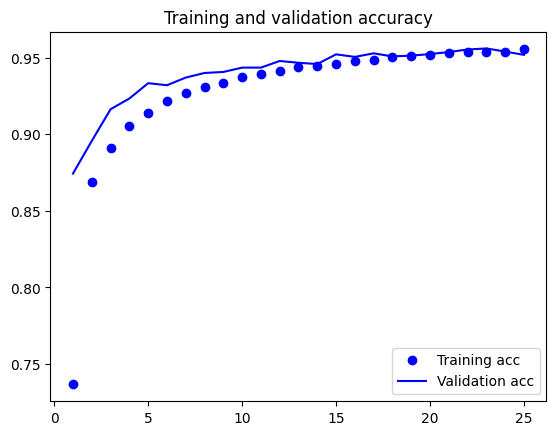

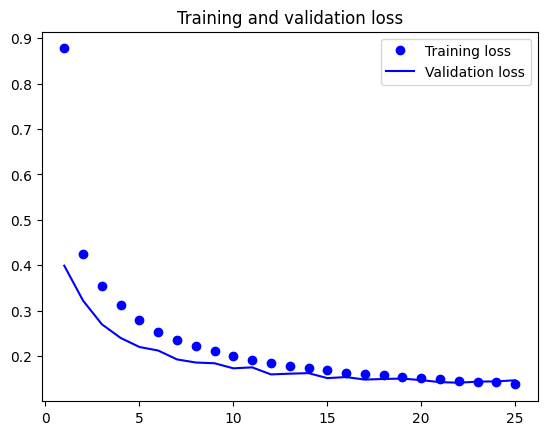

In [153]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


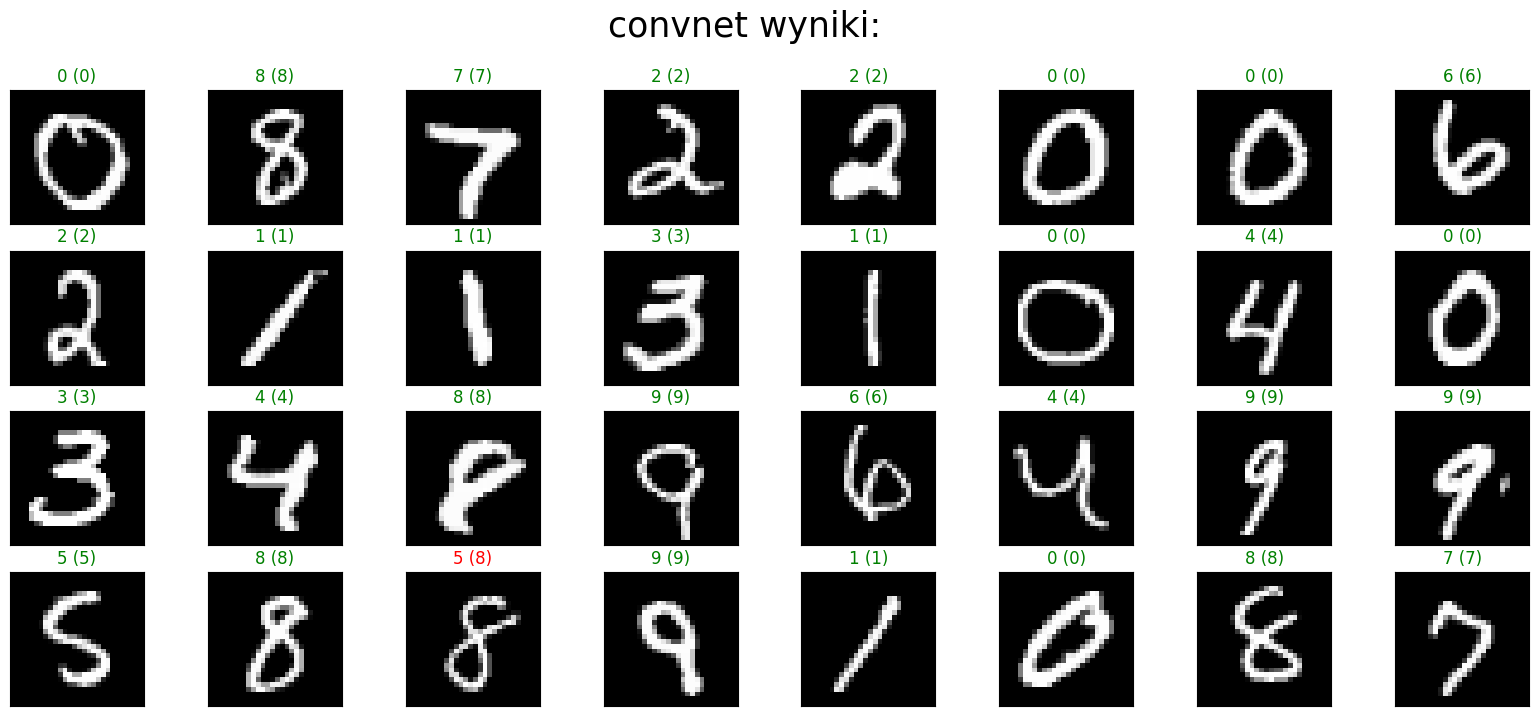

In [154]:
visualize_model_predictions(model, x_test, y_test,"convnet")

## 2.3 Konwolucja model v3
W dotychczasowych przykładach przed warstwą gęstą dodawaliśmy warstę płaską. Tutaj będzie podobnie, ale przed warstwą płaską dodamy warstwy konwolucyjne i maxpool.

In [155]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 16)          2064      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 3, 3, 16)        

In [156]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 8ms/step - loss: 0.3922 - accuracy: 0.8789 - val_loss: 0.1028 - val_accuracy: 0.9685
Epoch 2/25
422/422 [==============================] - 3s 6ms/step - loss: 0.1002 - accuracy: 0.9681 - val_loss: 0.0702 - val_accuracy: 0.9792
Epoch 3/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0714 - accuracy: 0.9776 - val_loss: 0.0678 - val_accuracy: 0.9785
Epoch 4/25
422/422 [==============================] - 3s 8ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.0638 - val_accuracy: 0.9812
Epoch 5/25
422/422 [==============================] - 4s 8ms/step - loss: 0.0479 - accuracy: 0.9846 - val_loss: 0.0465 - val_accuracy: 0.9845
Epoch 6/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0433 - accuracy: 0.9863 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 7/25
422/422 [==============================] - 3s 7ms/step - loss: 0.0377 - accuracy: 0.9880 - val_loss: 0.0464 - val_accuracy: 0.9853
Epoch 

## Ewaluacja modelu

In [157]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Precyzja: ',score[1])

Precyzja:  0.9902999997138977


Wykresy precyzji i błędu

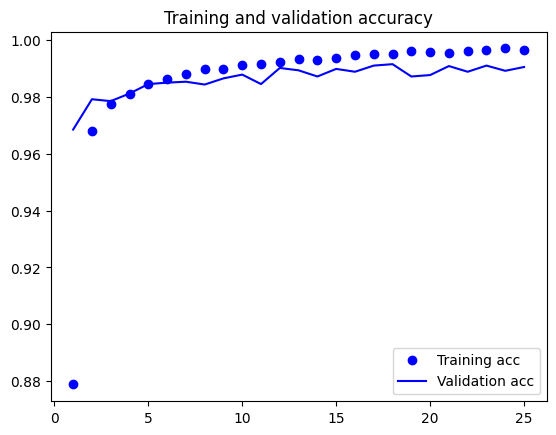

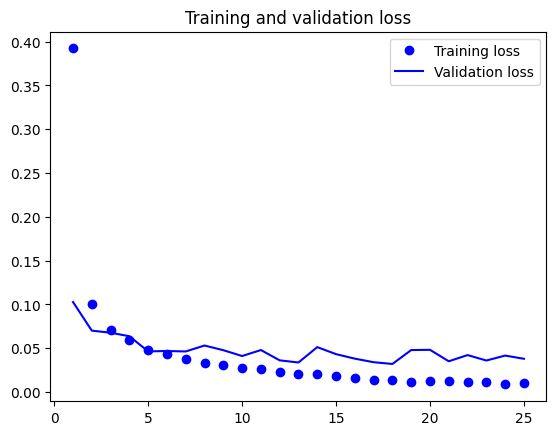

In [158]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


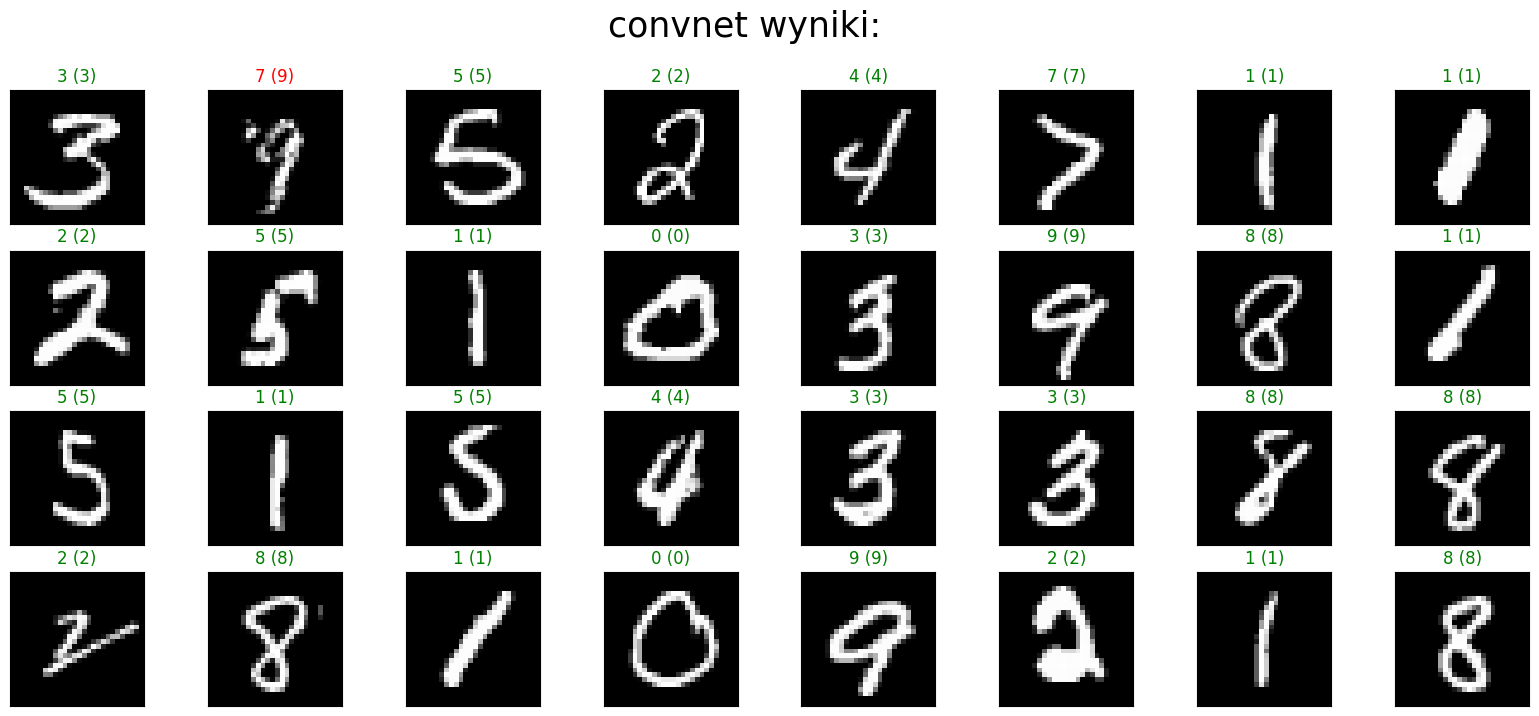

In [159]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy głównymi warstwami naszej sieci, aby uniknąć przeuczenia.

In [139]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)        

In [140]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 9ms/step - loss: 0.6871 - accuracy: 0.7697 - val_loss: 0.1493 - val_accuracy: 0.9603
Epoch 2/25
422/422 [==============================] - 4s 10ms/step - loss: 0.2656 - accuracy: 0.9146 - val_loss: 0.0969 - val_accuracy: 0.9705
Epoch 3/25
422/422 [==============================] - 3s 7ms/step - loss: 0.2066 - accuracy: 0.9339 - val_loss: 0.0831 - val_accuracy: 0.9742
Epoch 4/25
422/422 [==============================] - 3s 7ms/step - loss: 0.1753 - accuracy: 0.9437 - val_loss: 0.0647 - val_accuracy: 0.9808
Epoch 5/25
422/422 [==============================] - 3s 8ms/step - loss: 0.1546 - accuracy: 0.9506 - val_loss: 0.0589 - val_accuracy: 0.9847
Epoch 6/25
422/422 [==============================] - 3s 7ms/step - loss: 0.1381 - accuracy: 0.9556 - val_loss: 0.0532 - val_accuracy: 0.9835
Epoch 7/25
422/422 [==============================] - 3s 7ms/step - loss: 0.1296 - accuracy: 0.9588 - val_loss: 0.0505 - val_accuracy: 0.9863
Epoch

## Evaluate model:

In [141]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9929259419441223  Test accuracy:  0.9897000193595886


Wykresy precyzji i błędu

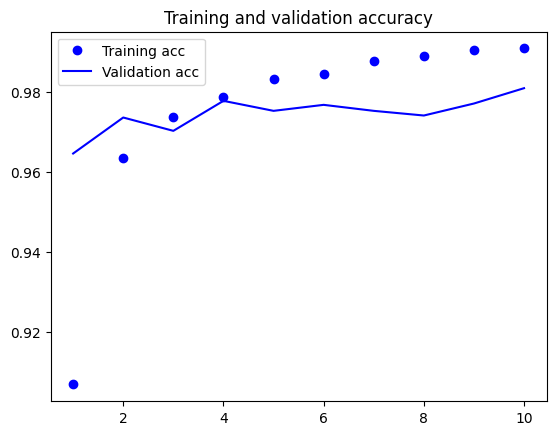

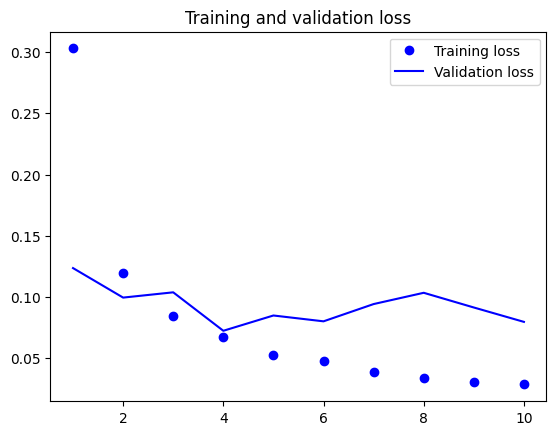

In [142]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


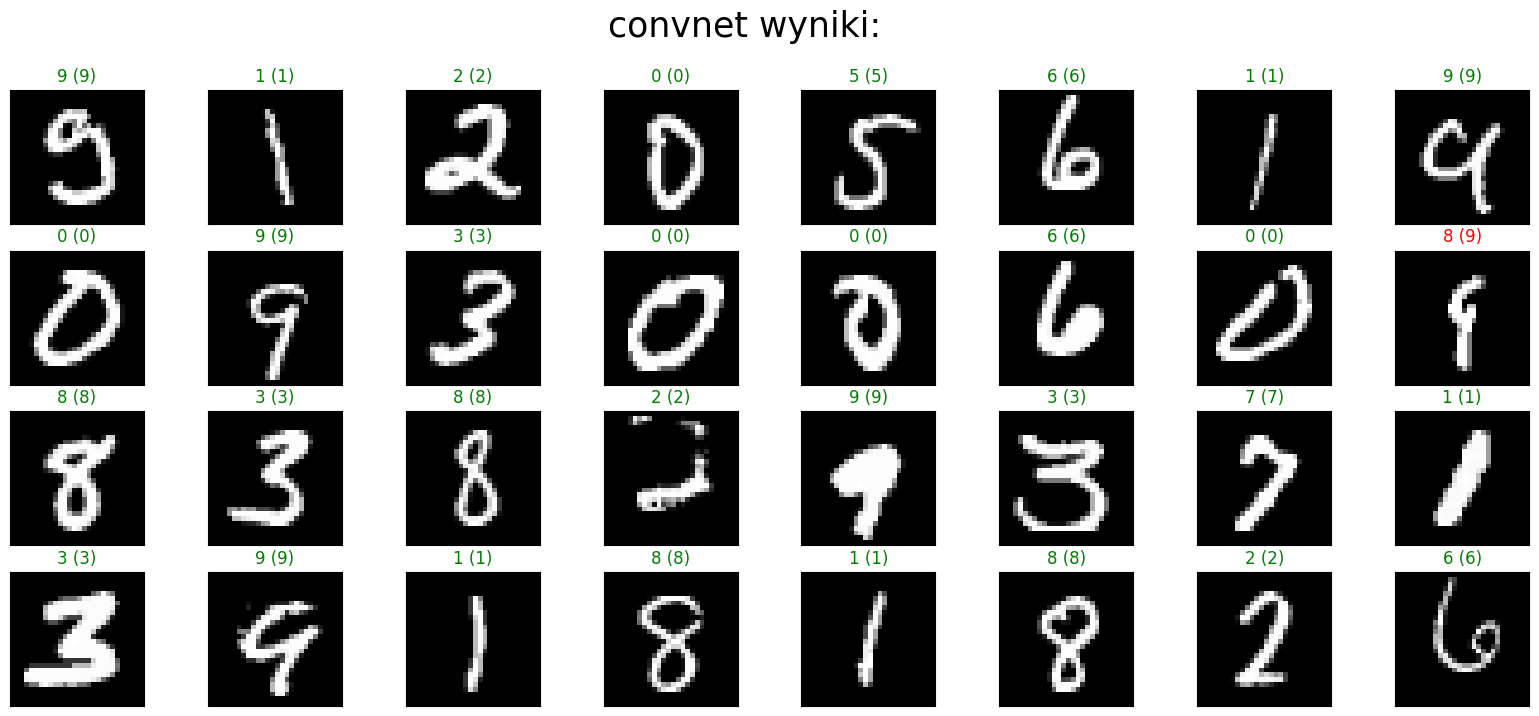

In [143]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja v2
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy warstwami naszej sieci, aby uniknąć przeuczenia.

In [144]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 32)        

In [145]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_valid, y_valid))

Epoch 1/25
422/422 [==============================] - 6s 10ms/step - loss: 0.7145 - accuracy: 0.7626 - val_loss: 0.1621 - val_accuracy: 0.9562
Epoch 2/25
422/422 [==============================] - 3s 7ms/step - loss: 0.2960 - accuracy: 0.9048 - val_loss: 0.1033 - val_accuracy: 0.9708
Epoch 3/25
422/422 [==============================] - 3s 8ms/step - loss: 0.2231 - accuracy: 0.9273 - val_loss: 0.0830 - val_accuracy: 0.9762
Epoch 4/25
422/422 [==============================] - 3s 8ms/step - loss: 0.1916 - accuracy: 0.9377 - val_loss: 0.0710 - val_accuracy: 0.9803
Epoch 5/25
422/422 [==============================] - 4s 8ms/step - loss: 0.1698 - accuracy: 0.9456 - val_loss: 0.0565 - val_accuracy: 0.9848
Epoch 6/25
422/422 [==============================] - 4s 9ms/step - loss: 0.1522 - accuracy: 0.9506 - val_loss: 0.0521 - val_accuracy: 0.9862
Epoch 7/25
422/422 [==============================] - 4s 10ms/step - loss: 0.1451 - accuracy: 0.9526 - val_loss: 0.0472 - val_accuracy: 0.9867
Epoc

## Evaluate model:

In [146]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9927036762237549  Test accuracy:  0.9887999892234802


Wykresy precyzji i błędu

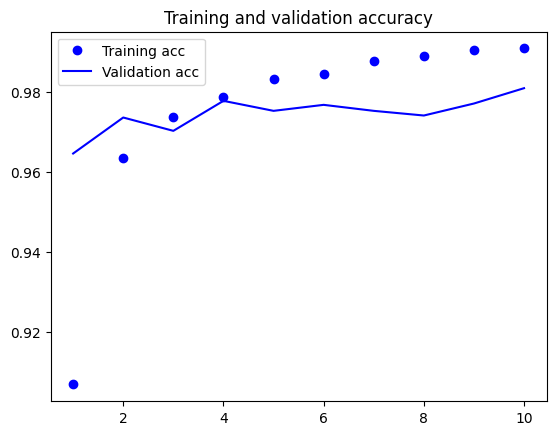

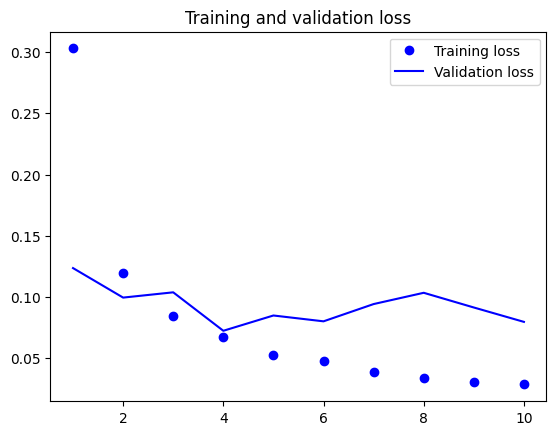

In [147]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


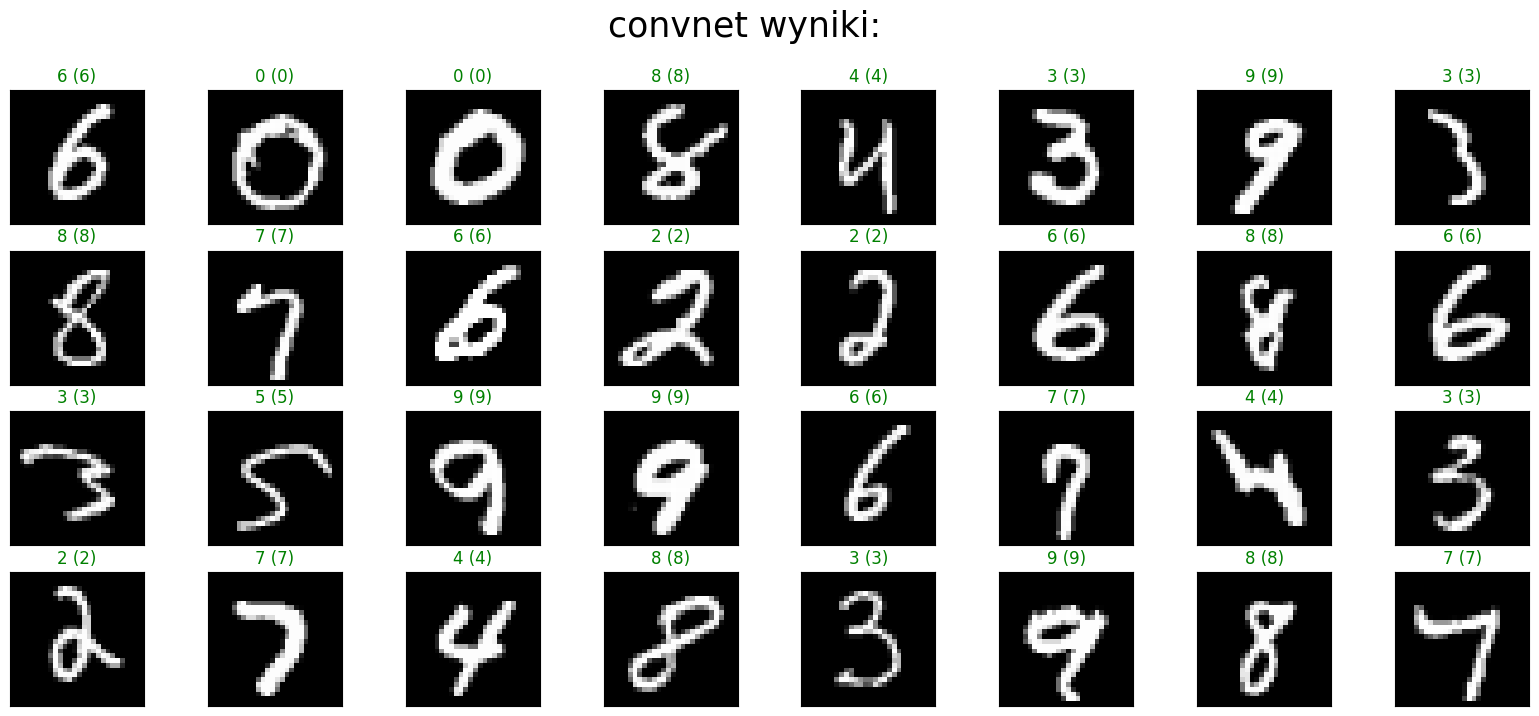

In [148]:
visualize_model_predictions(model, x_test, y_test,"convnet")

# 3 Regularyzacja v2
Nasz model ma obecnie dużo stopni swobody (ma DUŻO parametrów i dlatego może dopasować się do niemal każdej funkcji, jeśli tylko będziemy trenować wystarczająco długo). Oznacza to, że nasza sieć jest również podatna na przeuczenie.

W tej sekcji dodajmy warstwy dropout pomiędzy warstwami naszej sieci, aby uniknąć przeuczenia.

In [160]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 32)        

In [161]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_valid, y_valid))

Epoch 1/30
422/422 [==============================] - 6s 9ms/step - loss: 0.6782 - accuracy: 0.7714 - val_loss: 0.1604 - val_accuracy: 0.9523
Epoch 2/30
422/422 [==============================] - 3s 8ms/step - loss: 0.2762 - accuracy: 0.9100 - val_loss: 0.0885 - val_accuracy: 0.9732
Epoch 3/30
422/422 [==============================] - 3s 7ms/step - loss: 0.2149 - accuracy: 0.9318 - val_loss: 0.0760 - val_accuracy: 0.9787
Epoch 4/30
422/422 [==============================] - 3s 8ms/step - loss: 0.1850 - accuracy: 0.9405 - val_loss: 0.0618 - val_accuracy: 0.9828
Epoch 5/30
422/422 [==============================] - 4s 8ms/step - loss: 0.1565 - accuracy: 0.9511 - val_loss: 0.0570 - val_accuracy: 0.9847
Epoch 6/30
422/422 [==============================] - 3s 8ms/step - loss: 0.1494 - accuracy: 0.9526 - val_loss: 0.0514 - val_accuracy: 0.9850
Epoch 7/30
422/422 [==============================] - 3s 8ms/step - loss: 0.1335 - accuracy: 0.9565 - val_loss: 0.0485 - val_accuracy: 0.9855
Epoch 

## Evaluate model:

In [162]:
test_score = model.evaluate(x_test, y_test, verbose=0)
train_score = model.evaluate(x_train, y_train, verbose=0)

print('Train accuracy: ',train_score[1],' Test accuracy: ',test_score[1])

Train accuracy:  0.9938333630561829  Test accuracy:  0.989799976348877


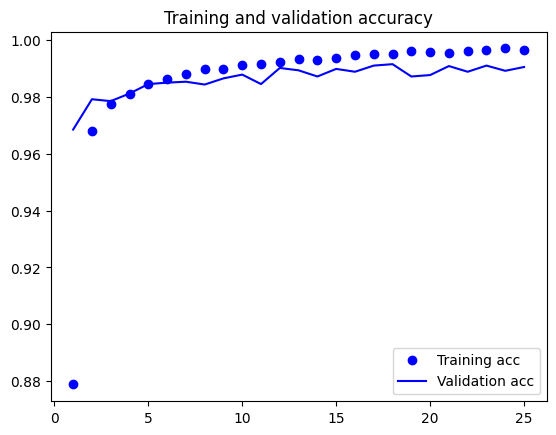

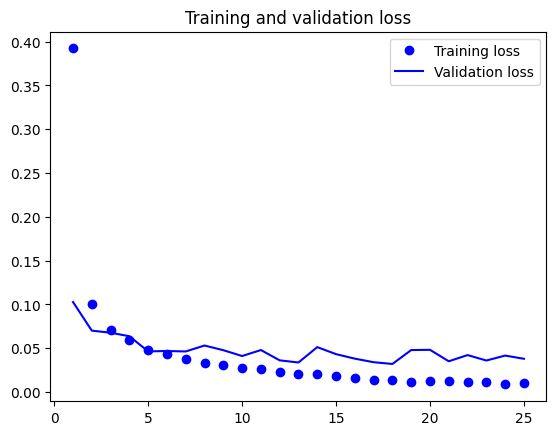

In [163]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


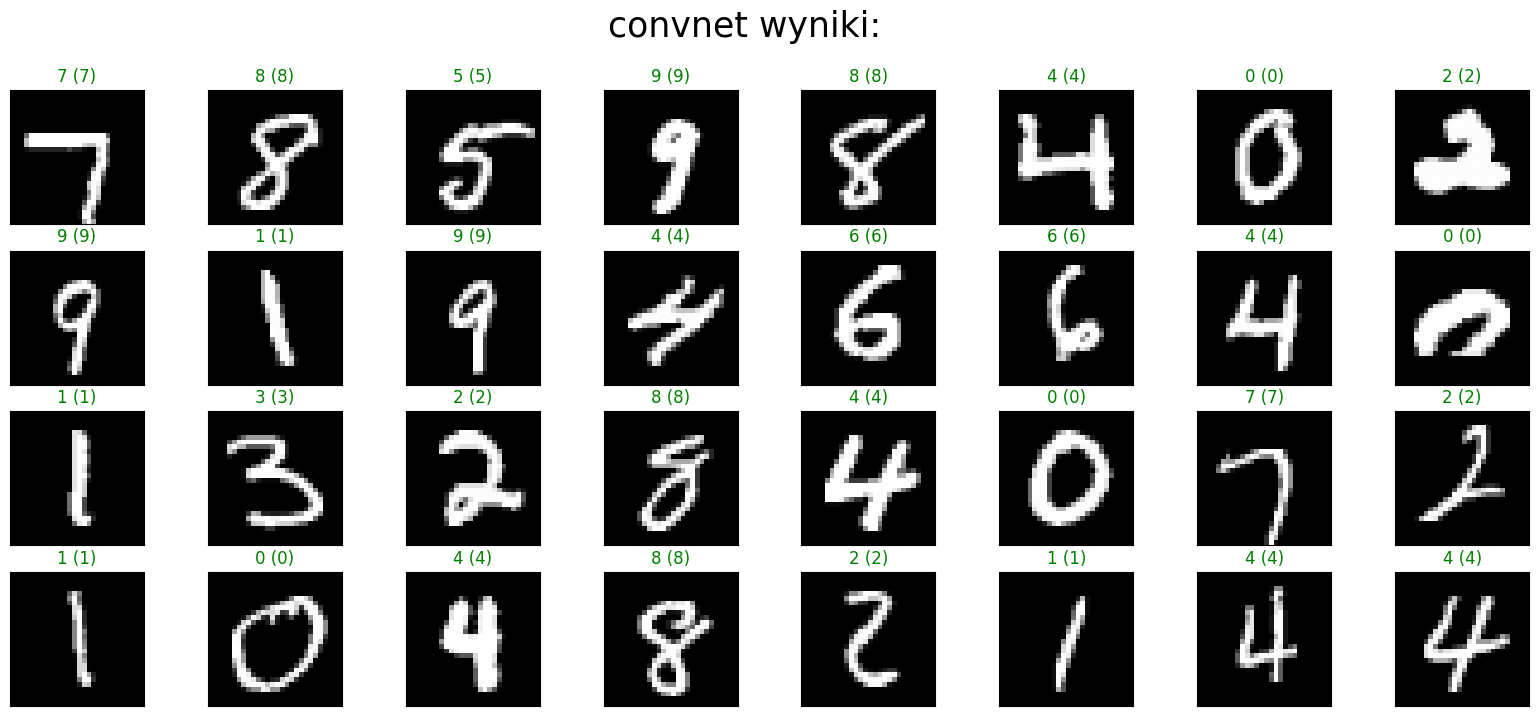

In [164]:
visualize_model_predictions(model, x_test, y_test,"convnet")

Wnioski

Najlepsze rezultaty uzyskuje model który stosuje konwolucję oraz regularyzacje w postaci warstw porzucających, ponieważ unika on wtedy przeuczenia. Najlepszym modelem jest model powyżej o nazwie Regularyzacja v3


```
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2,padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```



```
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_valid, y_valid))
```

